# Hypothesis 2: Infants are expected to demonstrate varying exploration patterns based on prior successes and errors
- Following successful trials, infants may shorten their exploration durations. In response to errors, they may exhibit prolonged gaze durations on the images. 
- After experiencing errors, they may demonstrate heightened eye-switching behaviour as they attempt to optimize their performance.


## Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro, levene, kruskal, sem, f_oneway
from sklearn.utils import resample
import random
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
from scipy.stats import kruskal, spearmanr
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import mean_absolute_error
import warnings
#import pymc as pm
#import arviz as az

In [2]:
#Read the dataset and drop NaN values

dataset = 'dataset_accuracy.csv'
data_original = pd.read_csv(dataset)
data_original.dropna(inplace=True)

data_original['durLookBottom'] = data_original['LookTotDurInL'] + data_original['LookTotDurInR'] #New variable: durLookBottom

data_original['FixNbInBottom'] = data_original['FixNbInL'] + data_original['FixNbInR'] #New variable: FixNbInBottom

data_original['durfixBottom'] = data_original['FixTotDurInL'] + data_original['FixTotDurInR'] #New variable: durFixBottom

data_original

session  trialno difficulty  accuracy period_in_trial  step_reached  \
0     curE002a        8       Easy       0.0     exploration             3   
1     curE002a        8       Easy       0.0        decision             3   
2     curE002a        9       Easy       1.0     exploration             3   
3     curE002a        9       Easy       1.0        decision             3   
4     curE002a       10       Easy       1.0     exploration             3   
...        ...      ...        ...       ...             ...           ...   
2079  curE122a       35       Hard       1.0        decision             3   
2080  curE122a       38       Hard       1.0     exploration             3   
2081  curE122a       38       Hard       1.0        decision             3   
2082  curE122a       48     Medium       0.0     exploration             3   
2083  curE122a       48     Medium       0.0        decision             3   

      durPeriodTotal  FixNb  FixNbInL  FixNbInR  ...         objL  \
0              11270     20        13         5  ...  V-1-G-1.png   
1                924      2         1         0  ...  V-1-G-1.png   
2               2498      6         3         2  ...  F-1-A-3.png   
3               2182      4         1         0  ...  F-1-A-3.png   
4               9912     11         3         5  ...  F-4-E-1.png   
...              ...    ...       ...       ...  ...          ...   
2079            1432      0         0         0  ...  V-4-F-1.png   
2080            2414      5         2         1  ...  O-2-J-1.png   
2081             582      2         2         0  ...  O-2-J-1.png   
2082            2332      2         1         0  ...  V-2-B-3.png   
2083             968      3         2         0  ...  V-2-B-3.png   

             objR         objT  sideChosen  sideMatch  timePeriodStarts  \
0     F-4-E-1.png  F-4-E-1.png        left      right            1962.0   
1     F-4-E-1.png  F-4-E-1.png        left      right           13232.0   
2     V-2-H-2.png  F-1-A-3.png        left       left            2024.0   
3     V-2-H-2.png  F-1-A-3.png        left       left            4522.0   
4     V-1-G-1.png  V-1-G-1.png       right      right            2046.0   
...           ...          ...         ...        ...               ...   
2079  V-4-A-4.png  V-4-F-1.png        left       left           18390.0   
2080  O-2-G-4.png  O-2-J-1.png        left       left            2716.0   
2081  O-2-G-4.png  O-2-J-1.png        left       left            5130.0   
2082  V-3-H-3.png  V-3-H-3.png        left      right            1488.0   
2083  V-3-H-3.png  V-3-H-3.png        left      right           17712.0   

      timePeriodEnds  durLookBottom  FixNbInBottom  durfixBottom  
0            13230.0           5480             18          4952  
1            14154.0            536              1           536  
2             4520.0           1670              5          1468  
3             6702.0            530              1           470  
4            11956.0           2658              8          2546  
...              ...            ...            ...           ...  
2079         19820.0              0              0             0  
2080          5128.0           1586              3          1510  
2081          5710.0            488              2           488  
2082         17710.0            596              1           596  
2083         20258.0            468              2           468  

[2084 rows x 35 columns]

In [3]:
# DF DATA PER TRIAL

# Exploration period duration
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
durExplorationTotal_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()
durExplorationTotal_df.rename(columns={'durPeriodTotal': 'durExplorationPeriod'}, inplace=True)                                              

# Decision period duration
decision_df = data_original[data_original['period_in_trial'] == 'decision']
durDecisionTotal_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['durPeriodTotal'].sum().reset_index()
durDecisionTotal_df.rename(columns={'durPeriodTotal': 'durDecisionPeriod'}, inplace=True)

# Trial duration
trialduration_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durPeriodTotal'].sum().reset_index()

# Accuracy
decision_df = data_original[data_original['period_in_trial'] == 'decision']
accuracy_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['accuracy'].sum().reset_index()

# Side Chosen
decision_df = data_original[data_original['period_in_trial'] == 'decision']
sideChosen_df = decision_df.groupby(['session', 'trialno', 'difficulty']) ['sideChosen'].sum().reset_index()

#Number of switches during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
SwitchesExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesExploration_df.rename(columns={'NbSwitches': 'SwitchesExplorationPeriod'}, inplace=True)   

#Number of switches during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
SwitchesDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()
SwitchesDecision_df.rename(columns={'NbSwitches': 'SwitchesDecisionPeriod'}, inplace=True)   

#Number of switches in total
SwitchesTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['NbSwitches'].sum().reset_index()

#Fixation number during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbExploration_df.rename(columns={'FixNb': 'FixNbExplorationPeriod'}, inplace=True)   

#Fixation number during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixNbDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()
FixNbDecision_df.rename(columns={'FixNb': 'FixNbDecisionPeriod'}, inplace=True)   

#Fixation number in total
FixNbTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNb'].sum().reset_index()

#Fixation number in top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixNbTD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTD_df.rename(columns={'FixNbInT': 'FixNbInTDecision'}, inplace=True)   

#Fixation number in top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbTE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()
FixNbTE_df.rename(columns={'FixNbInT': 'FixNbInTExploration'}, inplace=True) 

#Fixation number in Bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixNbBottom_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()
FixNbBottom_df.rename(columns={'FixNbInBottom': 'FixNbInBottomExploration'}, inplace=True)

#Fixation number in Bottom during both periods
FixNbBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNbInBottom'].sum().reset_index()

#Fixation number in Top during both periods
FixNbInTTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixNbInT'].sum().reset_index()

# Look total duration in top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTDecision_df.rename(columns={'LookTotDurInT': 'LookDurInTDecision'}, inplace=True)   

# Look total duration in top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()
LookDurTExploration_df.rename(columns={'LookTotDurInT': 'LookDurInTExploration'}, inplace=True)  

# Look total duration in bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
LookDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBE_df.rename(columns={'durLookBottom': 'durLookBottomExploration'}, inplace=True)

# Look total duration in bottom cards during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
LookDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()
LookDurBD_df.rename(columns={'durLookBottom': 'durLookBottomDecision'}, inplace=True)

# Look total duration in Bottom cards during both periods
LookDurBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durLookBottom'].sum().reset_index()

# Look total duration in Top Card during both periods
LookDurTopTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['LookTotDurInT'].sum().reset_index()

# Fixation duration of top card during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurTDecision_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTDecision_df.rename(columns={'FixTotDurInT': 'FixDurInTDecision'}, inplace=True)   

# Fixation duration of top card during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurTExploration_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()
FixDurTExploration_df.rename(columns={'FixTotDurInT': 'FixDurInTExploration'}, inplace=True)  

# Fixation duration of bottom cards during exploration period
exploration_df = data_original[data_original['period_in_trial'] == 'exploration']
FixDurBE_df = exploration_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBE_df.rename(columns={'durfixBottom': 'durfixBottomExploration'}, inplace=True)

# Fixation duration of bottom cards during decision period
decision_df = data_original[data_original['period_in_trial'] == 'decision']
FixDurBD_df = decision_df.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()
FixDurBD_df.rename(columns={'durfixBottom': 'durfixBottomDecision'}, inplace=True)

# Fixation duration of Bottom cards during both periods
FixDurBottomTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['durfixBottom'].sum().reset_index()

# Fixation duration of Top card during both periods
FixDurTopTotal_df = data_original.groupby(['session', 'trialno', 'difficulty'])['FixTotDurInT'].sum().reset_index()

merged_filtered_data = accuracy_df.merge(sideChosen_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(trialduration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durExplorationTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(durDecisionTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(SwitchesTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(SwitchesDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(FixNbExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbTD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottom_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixNbInTTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data = merged_filtered_data.merge(LookDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(LookDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')


merged_filtered_data = merged_filtered_data.merge(FixDurTDecision_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTExploration_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBE_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBD_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurBottomTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')
merged_filtered_data = merged_filtered_data.merge(FixDurTopTotal_df, on=['session', 'trialno', 'difficulty'], how='outer')

merged_filtered_data

session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
0     curE002a        8       Easy       0.0       left           12194   
1     curE002a        9       Easy       1.0       left            4680   
2     curE002a       10       Easy       1.0      right           12826   
3     curE002a       11     Medium       1.0      right            3910   
4     curE002a       12     Medium       0.0       left           15256   
...        ...      ...        ...       ...        ...             ...   
1037  curE122a       27     Medium       1.0       left           14690   
1038  curE122a       28     Medium       1.0      right           14362   
1039  curE122a       35       Hard       1.0       left           18326   
1040  curE122a       38       Hard       1.0       left            2996   
1041  curE122a       48     Medium       0.0       left            3300   

      durExplorationPeriod  durDecisionPeriod  NbSwitches  \
0                    11270                924           6   
1                     2498               2182           2   
2                     9912               2914           4   
3                     2328               1582           3   
4                    14272                984           6   
...                    ...                ...         ...   
1037                 13092               1598           2   
1038                 13796                566           4   
1039                 16894               1432           5   
1040                  2414                582           3   
1041                  2332                968           2   

      SwitchesExplorationPeriod  ...  durLookBottomExploration  \
0                             6  ...                      5480   
1                             2  ...                      1670   
2                             3  ...                      2658   
3                             2  ...                       994   
4                             5  ...                      7554   
...                         ...  ...                       ...   
1037                          2  ...                      9398   
1038                          3  ...                      6946   
1039                          5  ...                     11690   
1040                          2  ...                      1586   
1041                          1  ...                       596   

      durLookBottomDecision  durLookBottom  LookTotDurInT  FixDurInTDecision  \
0                       536           6016           1208                298   
1                       530           2200           2176               1466   
2                       106           2764           2020                798   
3                       470           1464           1780                646   
4                       476           8030           1296                406   
...                     ...            ...            ...                ...   
1037                    394           9792           1484                876   
1038                    474           7420            288                  0   
1039                      0          11690            118                  0   
1040                    488           2074            502                  0   
1041                    468           1064           2104                390   

      FixDurInTExploration  durfixBottomExploration  durfixBottomDecision  \
0                      298                     4952                   536   
1                     1466                     1468                   470   
2                      798                     2546                   364   
3                      646                      960                   420   
4                      406                     7048                   476   
...                    ...                      ...                   ...   
1037                   876                     8682                   308   
103

In [4]:
filtered_data = merged_filtered_data.dropna() 
filtered_data

filtered_data.sort_values(by=['session', 'trialno'], inplace=True)

mask = (
    (filtered_data['trialno'].shift(1) == filtered_data['trialno'] - 1) |  # Check if the trialno is preceded by the previous trialno
    (filtered_data['trialno'].shift(-1) == filtered_data['trialno'] + 1) | # Check if the trialno is followed by a consecutive trialno
    (filtered_data['trialno'].shift(1).isna()) |               # Check if the trialno has no previous trialno
    (filtered_data['trialno'].shift(-1).isna())                # Check if the trialno has no following trialno
)

data = filtered_data[mask]

data['prior_accuracy'] = data.groupby('session')['accuracy'].shift(1)

data.loc[~(data['trialno'] - 1 == data['trialno'].shift(1)), 'prior_accuracy'] = float('NaN')

data.reset_index(drop=True, inplace=True)

data = data.drop(data.index[-1])

data.dropna(inplace=True)

data

C:\Users\I587504\AppData\Local\Temp\ipykernel_50192\2884652669.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['prior_accuracy'] = data.groupby('session')['accuracy'].shift(1)


session  trialno difficulty  accuracy sideChosen  durPeriodTotal  \
1    curE002a        9       Easy       1.0       left            4680   
2    curE002a       10       Easy       1.0      right           12826   
3    curE002a       11     Medium       1.0      right            3910   
4    curE002a       12     Medium       0.0       left           15256   
5    curE002a       13     Medium       1.0       left           15846   
..        ...      ...        ...       ...        ...             ...   
857  curE122a        9       Easy       1.0      right           13228   
859  curE122a       16       Easy       0.0       left            7378   
861  curE122a       26     Medium       0.0       left            2944   
862  curE122a       27     Medium       1.0       left           14690   
863  curE122a       28     Medium       1.0      right           14362   

     durExplorationPeriod  durDecisionPeriod  NbSwitches  \
1                    2498               2182           2   
2                    9912               2914           4   
3                    2328               1582           3   
4                   14272                984           6   
5                   13628               2218           7   
..                    ...                ...         ...   
857                 11728               1500           6   
859                  6080               1298           1   
861                  2378                566           2   
862                 13092               1598           2   
863                 13796                566           4   

     SwitchesExplorationPeriod  ...  durLookBottomDecision  durLookBottom  \
1                            2  ...                    530           2200   
2                            3  ...                    106           2764   
3                            2  ...                    470           1464   
4                            5  ...                    476           8030   
5                            6  ...                    576           7244   
..                         ...  ...                    ...            ...   
857                          5  ...                    482           8678   
859                          1  ...                    270           4430   
861                          1  ...                    142           1302   
862                          2  ...                    394           9792   
863                          3  ...                    474           7420   

     LookTotDurInT  FixDurInTDecision  FixDurInTExploration  \
1             2176               1466                  1466   
2             2020                798                   798   
3             1780                646                   646   
4             1296                406                   406   
5             2850               1138                  1138   
..             ...                ...                   ...   
857           1232                842                   842   
859           1974                592                   592   
861            570                  0                     0   
862           1484                876                   876   
863            288                  0                     0   

     durfixBottomExploration  durfixBottomDecision  durfixBottom  \
1                       1468                   470          1938   
2                       2546                   364          2910   
3                        960                   420          1380   
4                       7048                   476          7524   
5                       6218                   522          6740   
..                       ...                   ...           ...   
857                     7492                   386          7878   
859                     3844                   410          4254   
861                     1132                   142          1274   
862                     8682      

## Features + Prior Accuracy Analysis

### Acuracy vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 3.148286558396864e-24
Shapiro-Wilk test for 1.0: p-value = 2.7576353968767484e-26
Levene's test for homogeneity of variances: p-value = 0.14150776523705602
Kruskal-Wallis test:
H-statistic: 2.162943061966686
p-value: 0.14137368533886085
Mean Accuracy by Prior Accuracy:
prior_accuracy
0.0    0.569395
1.0    0.510264
Name: accuracy, dtype: float64
Median Accuracy by Prior Accuracy:
prior_accuracy
0.0    1.0
1.0    1.0
Name: accuracy, dtype: float64
SEM Accuracy by Prior Accuracy:
prior_accuracy
0.0    0.029592
1.0    0.027111
Name: accuracy, dtype: float64


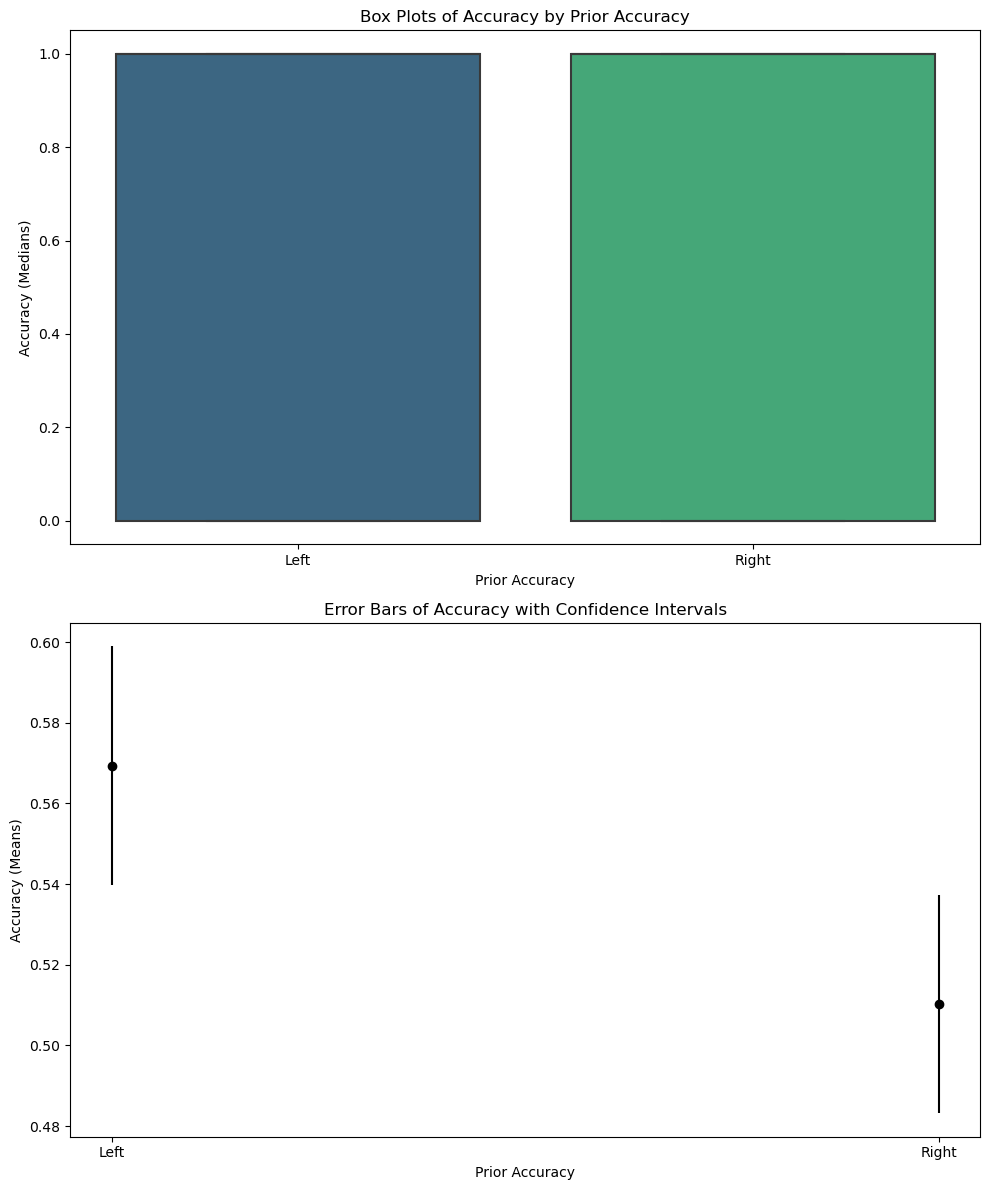

In [77]:
# Accuracy by prior accuracy 

accuracy_by_prior_accuracy = [data[data['prior_accuracy'] == level]['accuracy'] for level in data['prior_accuracy'].unique()]
accuracy_by_prior_accuracy = [group.dropna() for group in accuracy_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['accuracy']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*accuracy_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*accuracy_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of Accuracy by accuracy
mean_accuracy_by_prior_accuracy = data.groupby('prior_accuracy')['accuracy'].mean()
sem_accuracy_by_prior_accuracy = data.groupby('prior_accuracy')['accuracy'].sem()
median_accuracy_by_prior_accuracy = data.groupby('prior_accuracy')['accuracy'].median()
print("Mean Accuracy by Prior Accuracy:")
print(mean_accuracy_by_prior_accuracy)
print("Median Accuracy by Prior Accuracy:")
print(median_accuracy_by_prior_accuracy)
print("SEM Accuracy by Prior Accuracy:")
print(sem_accuracy_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='accuracy', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Accuracy (Medians)')
ax1.set_title('Box Plots of Accuracy by Prior Accuracy')
ax1.set_xticklabels(['Left', 'Right'])  

ax2.errorbar(np.arange(len(mean_accuracy_by_prior_accuracy)), mean_accuracy_by_prior_accuracy, yerr=sem_accuracy_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Accuracy (Means)')
ax2.set_title('Error Bars of Accuracy with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_accuracy_by_prior_accuracy)))
ax2.set_xticklabels(mean_accuracy_by_prior_accuracy.index)
ax2.set_xticklabels(['Left', 'Right']) 

plt.tight_layout()
plt.show()

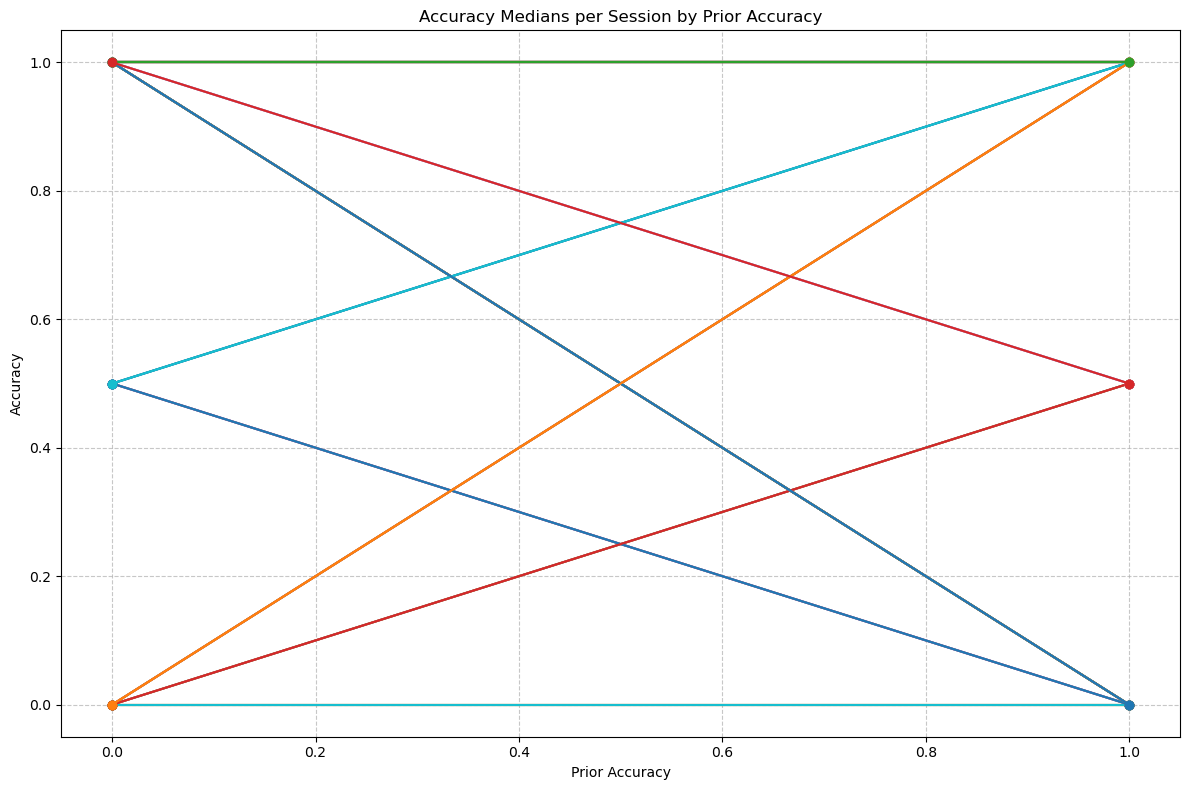

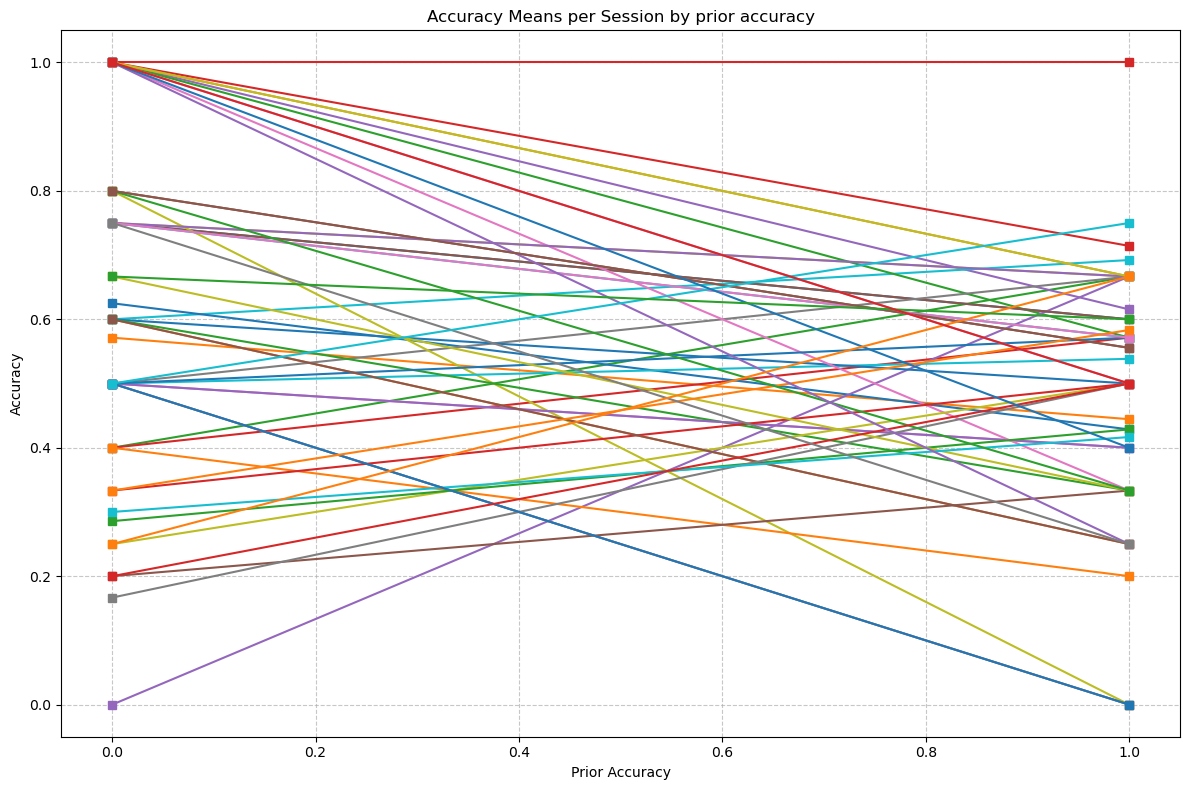

In [78]:
# Accuracy by prior accuracy per session

#Medians
session_accuracy = data.groupby(['session', 'prior_accuracy'])['accuracy'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_accuracy.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_accuracy_session = session_accuracy.loc[session][available_prior_accuracy]
        plt.plot(median_accuracy_session.index, median_accuracy_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Accuracy Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
#plt.legend()
plt.show()

session_accuracy_mean = data.groupby(['session', 'prior_accuracy'])['accuracy'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_accuracy_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_accuracy_session = session_accuracy_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_accuracy_session.index, mean_accuracy_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Accuracy Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Accuracy')
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()
plt.tight_layout()
plt.show()

### Total Trial Duration vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 4.3884446302999e-14
Shapiro-Wilk test for 1.0: p-value = 6.276893587917011e-17
Levene's test for homogeneity of variances: p-value = 0.8407480015873277
Kruskal-Wallis test:
H-statistic: 0.9417785765493688
p-value: 0.33182085665607886
Mean Total Trial duration by Prior Accuracy:
prior_accuracy
0.0    8721.430605
1.0    8420.744868
Name: durPeriodTotal, dtype: float64
SEM Total Trial Duration by Prior Accuracy:
prior_accuracy
0.0    301.340953
1.0    273.326987
Name: durPeriodTotal, dtype: float64


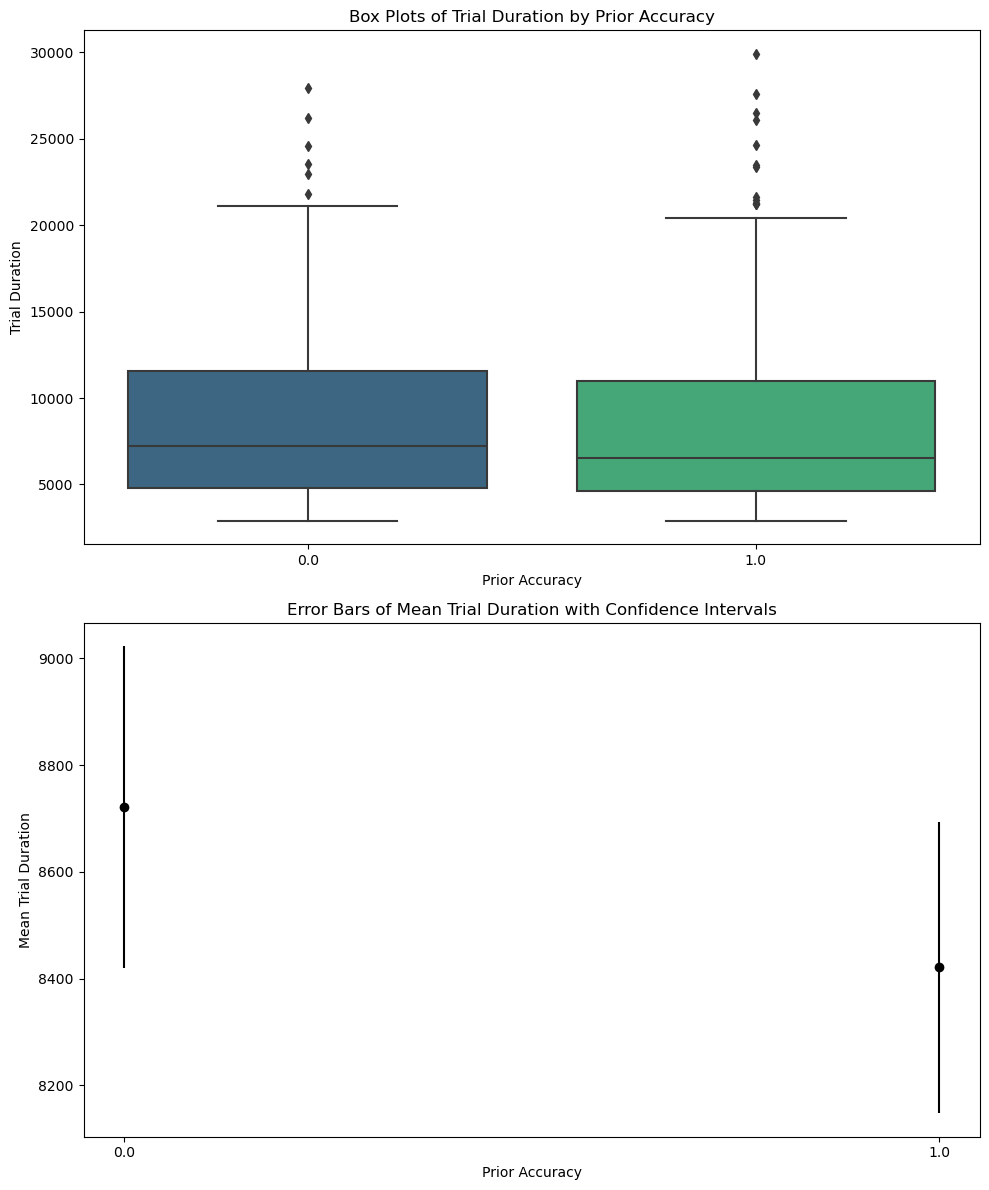

In [79]:
#Total trial duration vs. Prior Accuracy

durPeriodTotal_by_prior_accuracy = [data[data['prior_accuracy'] == level]['durPeriodTotal'] for level in data['prior_accuracy'].unique()]
durPeriodTotaln_by_prior_accuracy = [group.dropna() for group in durPeriodTotal_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['durPeriodTotal']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*durPeriodTotal_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*durPeriodTotal_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of total trial duration by accuracy
mean_trialduration_by_prior_accuracy = data.groupby('prior_accuracy')['durPeriodTotal'].mean()
sem_trialduration_by_prior_accuracy = data.groupby('prior_accuracy')['durPeriodTotal'].sem()
print("Mean Total Trial duration by Prior Accuracy:")
print(mean_trialduration_by_prior_accuracy)
print("SEM Total Trial Duration by Prior Accuracy:")
print(sem_trialduration_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='durPeriodTotal', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Trial Duration')
ax1.set_title('Box Plots of Trial Duration by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_trialduration_by_prior_accuracy)), mean_trialduration_by_prior_accuracy, yerr=sem_trialduration_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Mean Trial Duration')
ax2.set_title('Error Bars of Mean Trial Duration with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_trialduration_by_prior_accuracy)))
ax2.set_xticklabels(mean_trialduration_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

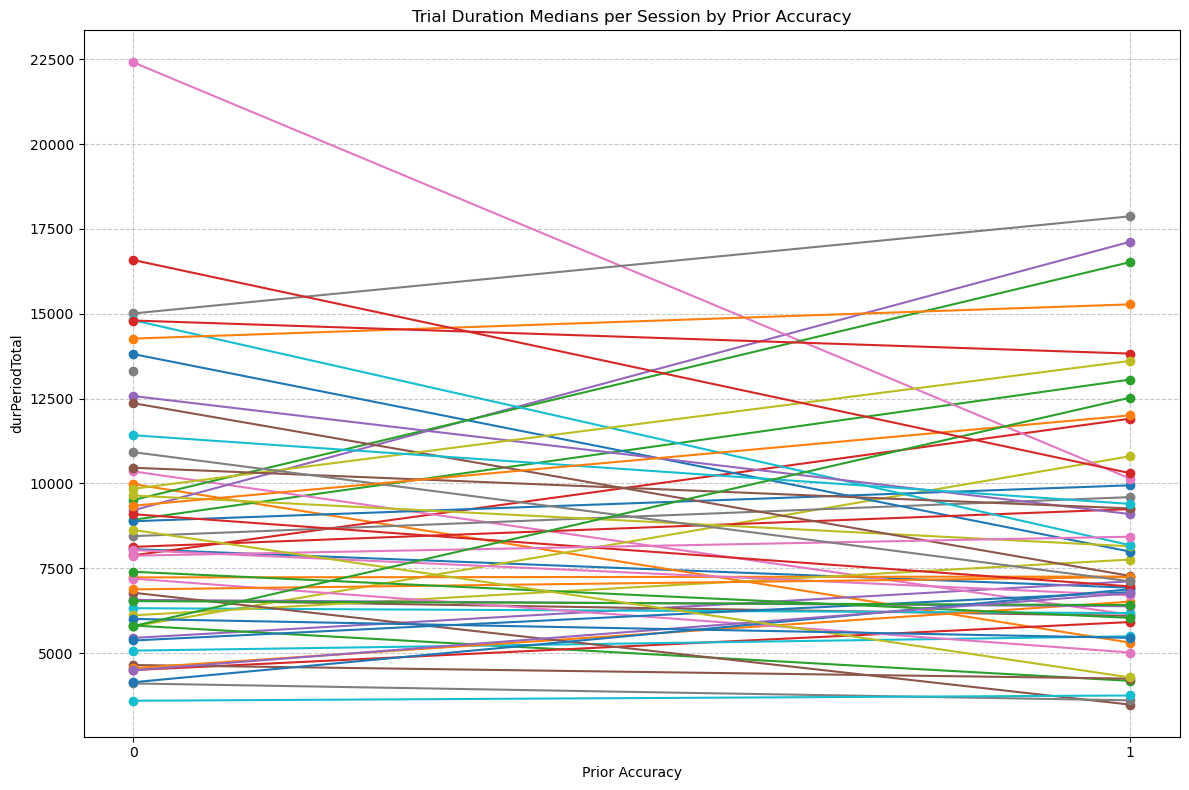

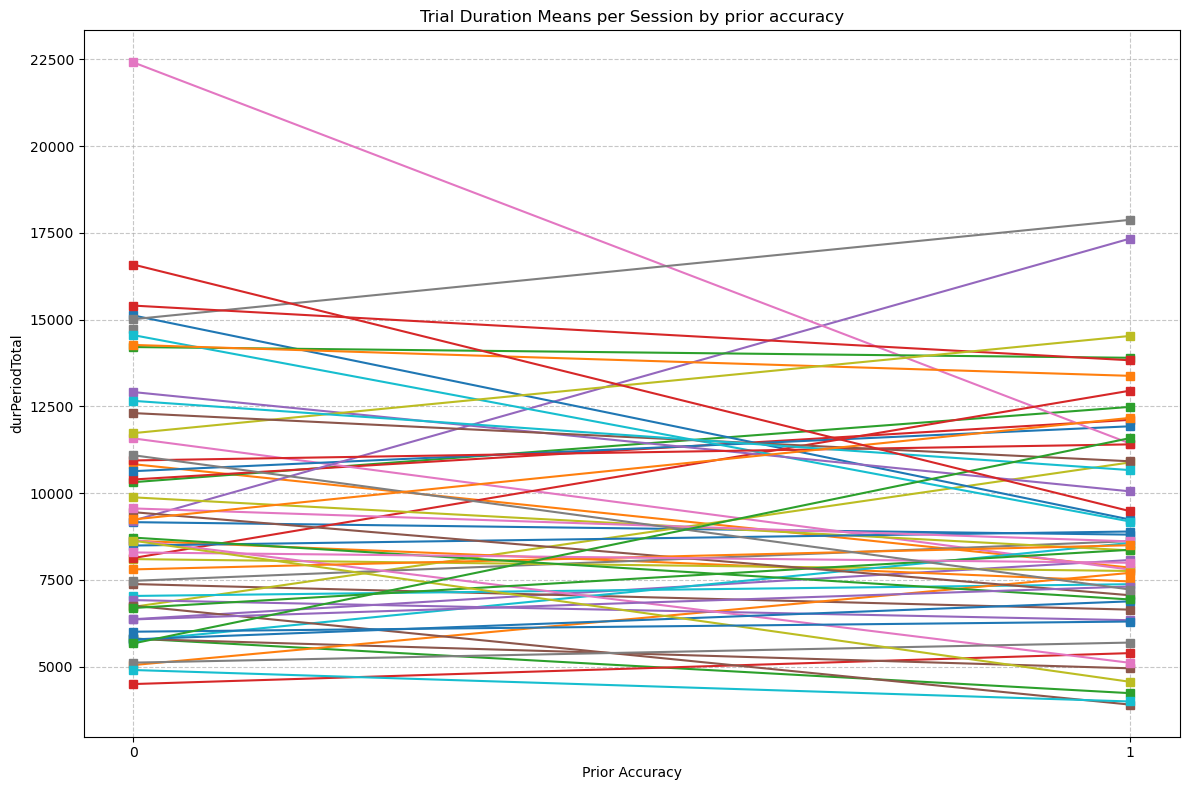

In [80]:
# Trial duration per session by prior accuracy per session

#Medians
session_dur_trial = data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_dur_trial.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_durtrial_session = session_dur_trial.loc[session][available_prior_accuracy]
        plt.plot(median_durtrial_session.index, median_durtrial_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Trial Duration Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('durPeriodTotal')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_dur_trial_mean = data.groupby(['session', 'prior_accuracy'])['durPeriodTotal'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_dur_trial_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_durtrial_session = session_dur_trial_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_durtrial_session.index, mean_durtrial_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Trial Duration Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('durPeriodTotal')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Duration of Exploration and Decision Periods vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.1026565079907773e-18
Shapiro-Wilk test for 1.0: p-value = 3.3771951014498574e-20
Levene's test for homogeneity of variances: p-value = 0.9518573445467459
Kruskal-Wallis test:
H-statistic: 0.246702501616173
p-value: 0.6194065780459908
Shapiro-Wilk test for 0.0: p-value = 2.148118235103074e-20
Shapiro-Wilk test for 1.0: p-value = 1.5148487254294336e-23
Levene's test for homogeneity of variances: p-value = 0.2639318324579871
Kruskal-Wallis test:
H-statistic: 1.0059663948613025
p-value: 0.3158711089929078
Mean Duration of Exploration by Prior Accuracy:
[5832.70462633 5757.40762463]
SEM Duration of Exploration by Prior Accuracy:
[251.47288523 222.84736413]
Mean Duration of Decision by Prior Accuracy:
[2888.72597865 2663.3372434 ]
SEM Duration of Decision by Prior Accuracy:
[145.96762756 123.07947782]


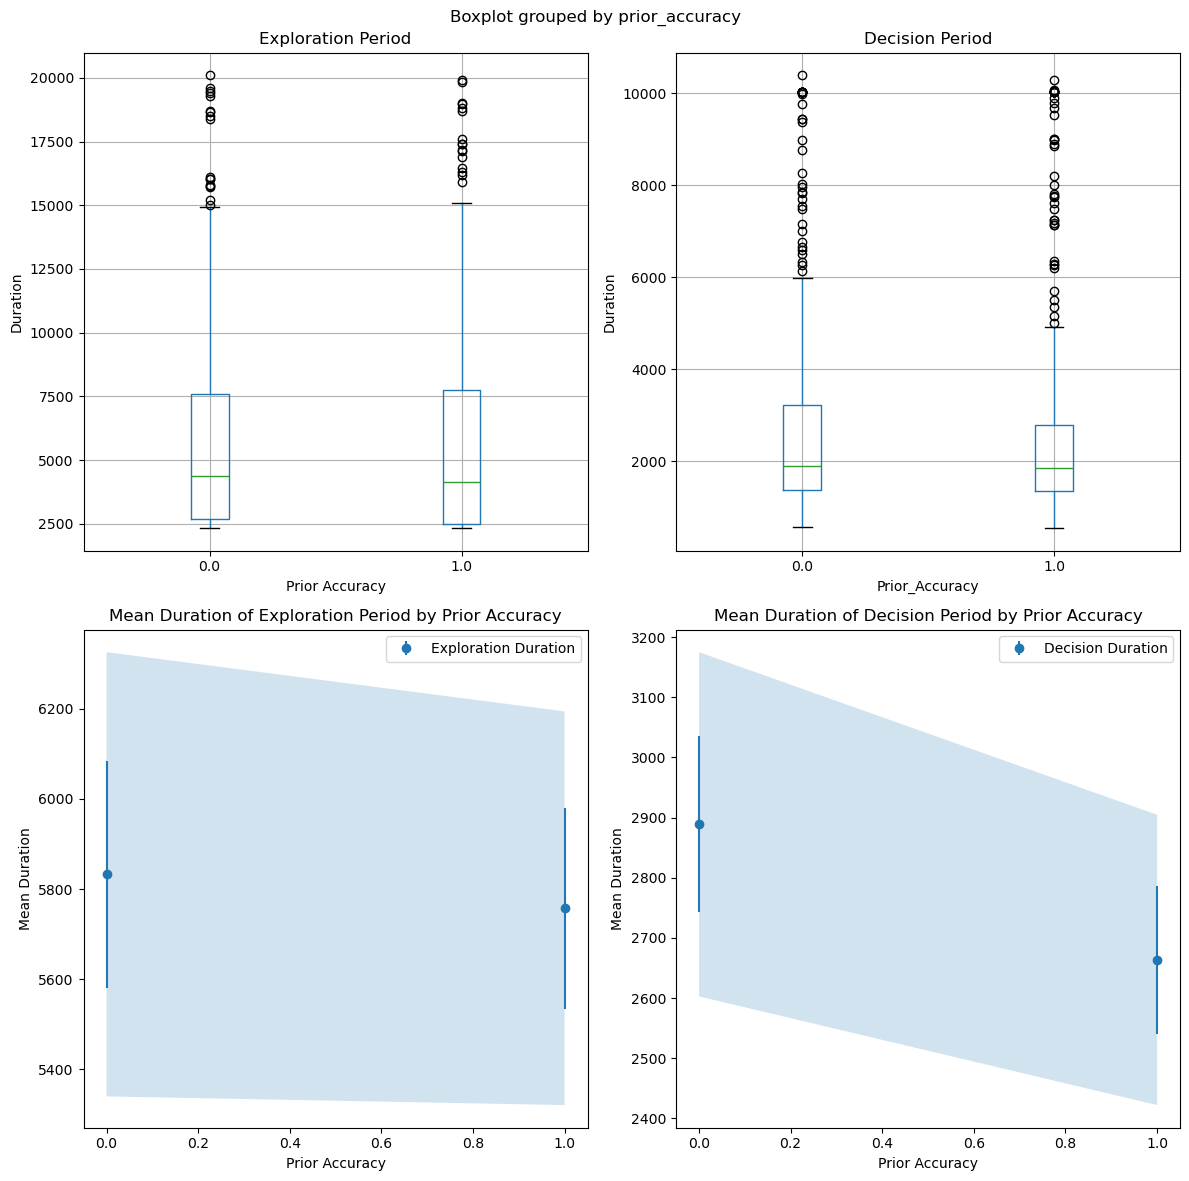

In [81]:
# Duration of both exploration and decision periods by.prior accuracy

DurExploration_by_prior_accuracy = [data[data['prior_accuracy'] == level]['durExplorationPeriod'] for level in data['prior_accuracy'].unique()]
DurExploration_by_prior_accuracy = [group.dropna() for group in DurExploration_by_prior_accuracy]

DurDecision_by_prior_accuracy = [data[data['prior_accuracy'] == level]['durDecisionPeriod'] for level in data['prior_accuracy'].unique()]
DurDecision_by_prior_accuracy = [group.dropna() for group in DurDecision_by_prior_accuracy]

# Shapiro-Wilk test for normality - Exploration
for group_name, group_data in data.groupby('prior_accuracy')['durExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances - Exploration
stat, p = levene(*DurExploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test - Exploration
H, p = kruskal(*DurExploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Shapiro-Wilk test for normality - Decision
for group_name, group_data in data.groupby('prior_accuracy')['durDecisionPeriod']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances - Decision
stat, p = levene(*DurDecision_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test - Decision
H, p = kruskal(*DurDecision_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of duration of exploration period by prior accuracy
mean_exp_duration_by_prior_accuracy = data.groupby('prior_accuracy')['durExplorationPeriod'].mean().values
sem_exp_duration_by_prior_accuracy = data.groupby('prior_accuracy')['durExplorationPeriod'].sem().values

# Confidence intervals for exploration
exploration_conf_intervals = 1.96 * sem_exp_duration_by_prior_accuracy  

print("Mean Duration of Exploration by Prior Accuracy:")
print(mean_exp_duration_by_prior_accuracy)
print("SEM Duration of Exploration by Prior Accuracy:")
print(sem_exp_duration_by_prior_accuracy)

# Mean and SEM of duration of decision period by prior accuracy
mean_dec_duration_by_prior_accuracy = data.groupby('prior_accuracy')['durDecisionPeriod'].mean().values
sem_dec_duration_by_prior_accuracy = data.groupby('prior_accuracy')['durDecisionPeriod'].sem().values

# Confidence intervals for decision 
decision_conf_intervals = 1.96 * sem_dec_duration_by_prior_accuracy  

print("Mean Duration of Decision by Prior Accuracy:")
print(mean_dec_duration_by_prior_accuracy)
print("SEM Duration of Decision by Prior Accuracy:")
print(sem_dec_duration_by_prior_accuracy)

# Plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Exploration Period Boxplot
data.boxplot(column='durExplorationPeriod', by='prior_accuracy', ax=axs[0, 0])
axs[0, 0].set_title('Exploration Period')
axs[0, 0].set_xlabel('Prior Accuracy')
axs[0, 0].set_ylabel('Duration')

# Decision Period Boxplot
data.boxplot(column='durDecisionPeriod', by='prior_accuracy', ax=axs[0, 1])
axs[0, 1].set_title('Decision Period')
axs[0, 1].set_xlabel('Prior_Accuracy')
axs[0, 1].set_ylabel('Duration')

# Error bars with confidence intervals
axs[1, 0].errorbar(np.arange(len(mean_exp_duration_by_prior_accuracy)), mean_exp_duration_by_prior_accuracy, yerr=sem_exp_duration_by_prior_accuracy, fmt='o', label='Exploration Duration')
axs[1, 0].fill_between(np.arange(len(mean_exp_duration_by_prior_accuracy)), mean_exp_duration_by_prior_accuracy - exploration_conf_intervals, mean_exp_duration_by_prior_accuracy + exploration_conf_intervals, alpha=0.2)
axs[1, 0].set_xlabel('Prior Accuracy')
axs[1, 0].set_ylabel('Mean Duration')
axs[1, 0].set_title('Mean Duration of Exploration Period by Prior Accuracy')
axs[1, 0].legend()

axs[1, 1].errorbar(np.arange(len(mean_dec_duration_by_prior_accuracy)), mean_dec_duration_by_prior_accuracy, yerr=sem_dec_duration_by_prior_accuracy, fmt='o', label='Decision Duration')
axs[1, 1].fill_between(np.arange(len(mean_dec_duration_by_prior_accuracy)), mean_dec_duration_by_prior_accuracy - decision_conf_intervals, mean_dec_duration_by_prior_accuracy + decision_conf_intervals, alpha=0.2)
axs[1, 1].set_xlabel('Prior Accuracy')
axs[1, 1].set_ylabel('Mean Duration')
axs[1, 1].set_title('Mean Duration of Decision Period by Prior Accuracy')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

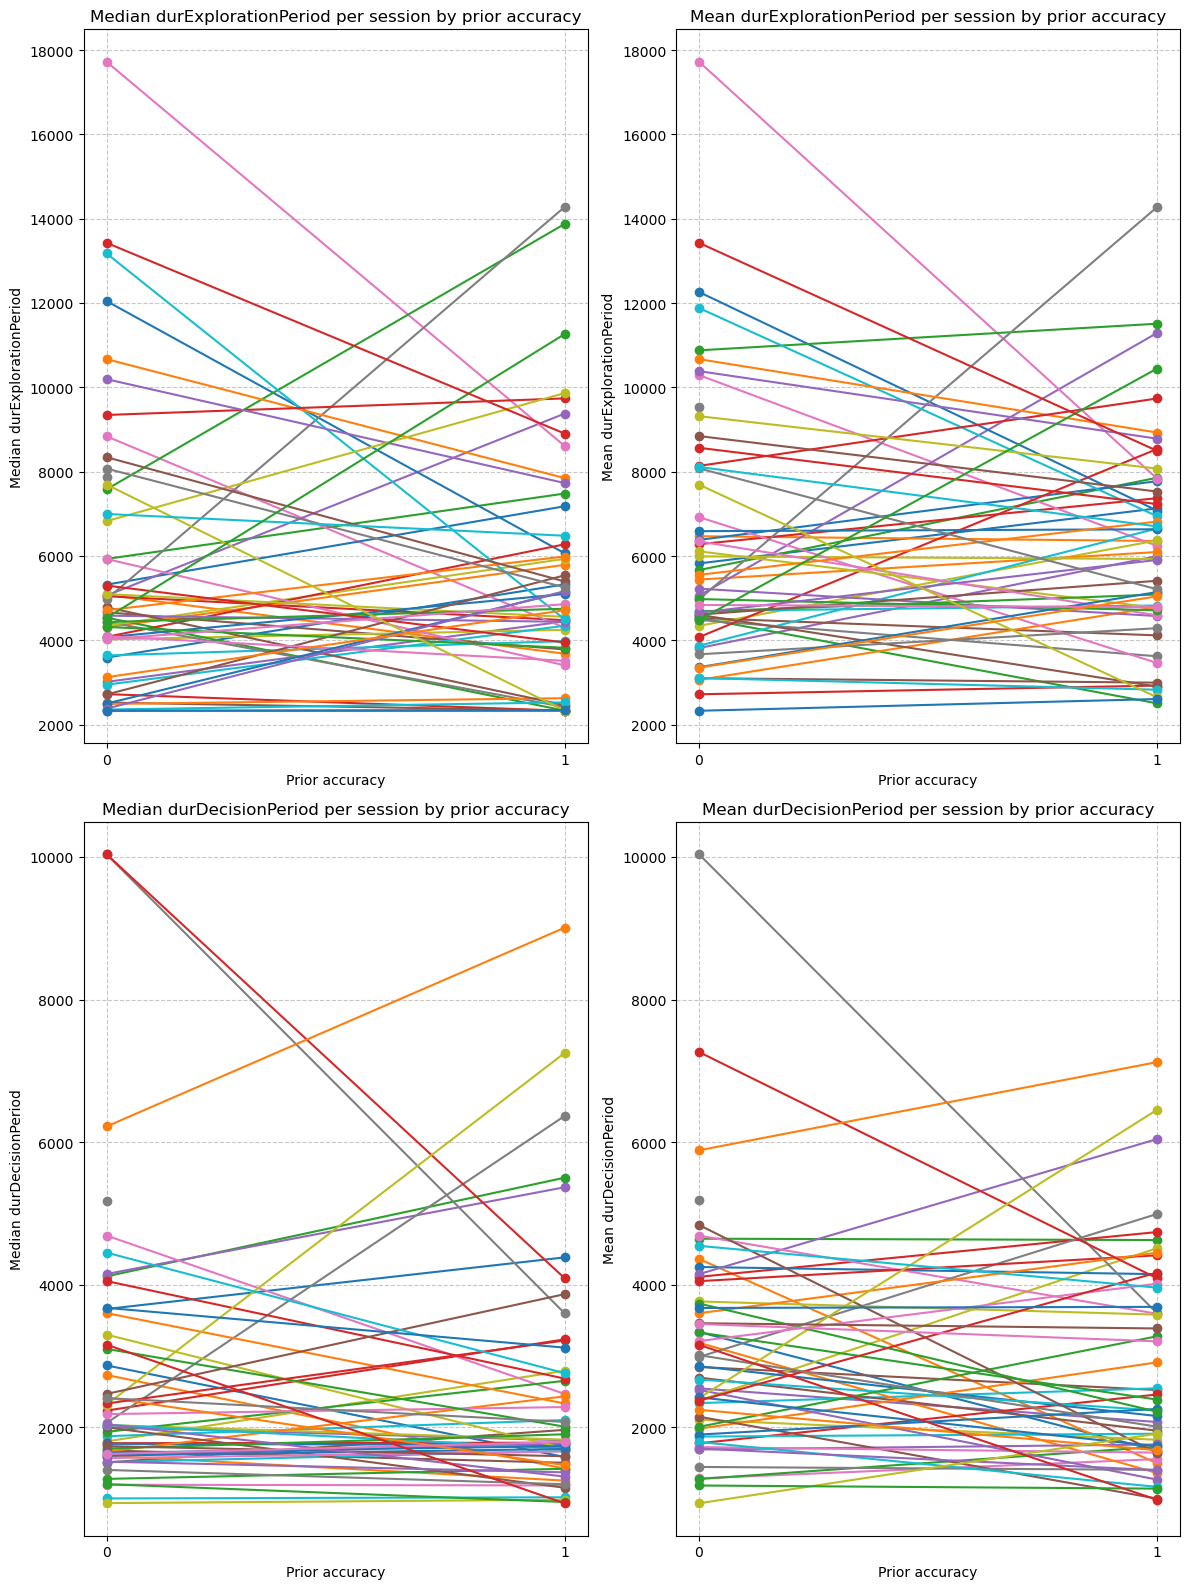

In [82]:
# Duration of both exploration and decision periods vs. prior accuracy per session

# Median durExplorationPeriod per session by prior accuracy 
durExplorationPeriod_per_trial_prior_accuracy = data.groupby(['session', 'trialno', 'prior_accuracy'])['durExplorationPeriod'].sum().reset_index()
durExplorationPeriod_per_trial_prior_accuracy.dropna(inplace=True)
median_durExplorationPeriod_per_session_prior_accuracy = durExplorationPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].median().unstack()

plt.figure(figsize=(12, 16))

all_sessions = median_durExplorationPeriod_per_session_prior_accuracy.index

plt.subplot(2, 2, 1)
for session in all_sessions:
    session_data = median_durExplorationPeriod_per_session_prior_accuracy.loc[session].dropna()
    plt.plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
plt.title('Median durExplorationPeriod per session by prior accuracy')
plt.xlabel('Prior accuracy')
plt.ylabel('Median durExplorationPeriod')
plt.xticks([0, 1]) 
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()

# Mean durExplorationPeriod per session by prior accuracy
mean_durExplorationPeriod_per_session_prior_accuracy = durExplorationPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['durExplorationPeriod'].mean().unstack()

plt.subplot(2, 2, 2)
for session in all_sessions:
    session_data = mean_durExplorationPeriod_per_session_prior_accuracy.loc[session].dropna()
    plt.plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
plt.title('Mean durExplorationPeriod per session by prior accuracy')
plt.xlabel('Prior accuracy')
plt.ylabel('Mean durExplorationPeriod')
plt.xticks([0, 1]) 
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()

# Median durDecisionPeriod per session by prior accuracy
durDecisionPeriod_per_trial_prior_accuracy = data.groupby(['session', 'trialno', 'prior_accuracy'])['durDecisionPeriod'].sum().reset_index()
durDecisionPeriod_per_trial_prior_accuracy.dropna(inplace=True)
median_durDecisionPeriod_per_session_prior_accuracy = durDecisionPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].median().unstack()

plt.subplot(2, 2, 3)
for session in all_sessions:
    session_data = median_durDecisionPeriod_per_session_prior_accuracy.loc[session].dropna()
    plt.plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
plt.title('Median durDecisionPeriod per session by prior accuracy')
plt.xlabel('Prior accuracy')
plt.ylabel('Median durDecisionPeriod')
plt.xticks([0, 1]) 
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()

# Mean durDecisionPeriod per session by prior accuracy 
mean_durDecisionPeriod_per_session_prior_accuracy = durDecisionPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['durDecisionPeriod'].mean().unstack()

plt.subplot(2, 2, 4)
for session in all_sessions:
    session_data = mean_durDecisionPeriod_per_session_prior_accuracy.loc[session].dropna()
    plt.plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
plt.title('Mean durDecisionPeriod per session by prior accuracy')
plt.xlabel('Prior accuracy')
plt.ylabel('Mean durDecisionPeriod')
plt.xticks([0, 1]) 
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()

plt.tight_layout()
plt.show()

### Look duration of bottom images (exploration period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 3.819213411434678e-17
Shapiro-Wilk test for 1.0: p-value = 5.4248560518885595e-14
Levene's test for homogeneity of variances: p-value = 0.7844097066450832
Kruskal-Wallis test:
H-statistic: 0.03717078153029395
p-value: 0.8471177533618407
Mean Look Duration during Exploration of Bottom cards by Prior Accuracy:
prior_accuracy
0.0    3305.928826
1.0    3237.360704
Name: durLookBottomExploration, dtype: float64
SEM Look Duration during Exploration of Bottom Cards by Prior Accuracy:
prior_accuracy
0.0    170.874263
1.0    141.590164
Name: durLookBottomExploration, dtype: float64


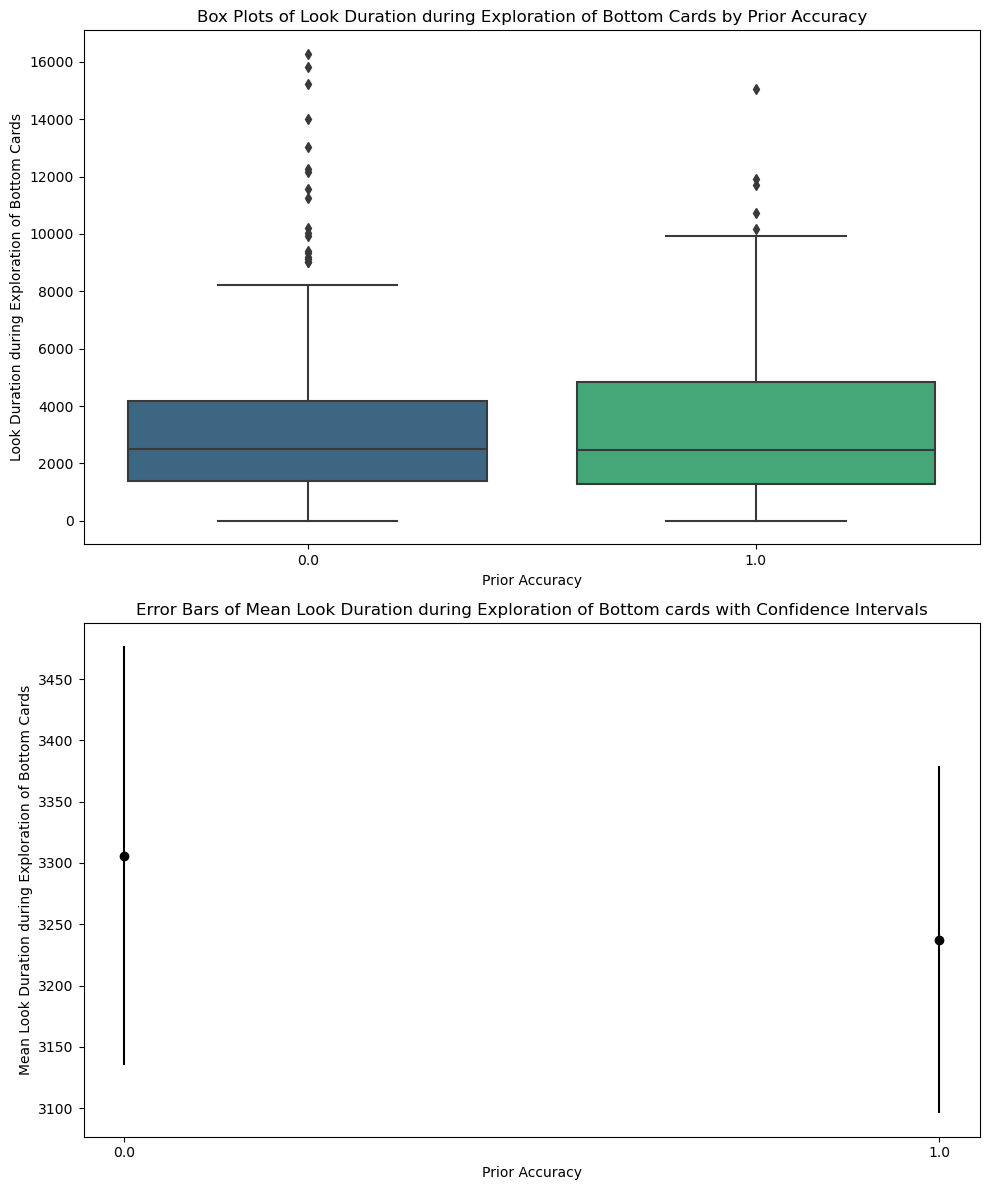

In [83]:
# durLookBottomExploration vs prior accuracy

LookDurBottomExploration_by_prior_accuracy = [data[data['prior_accuracy'] == level]['durLookBottomExploration'] for level in data['prior_accuracy'].unique()]
LookDurBottomExploration_by_prior_accuracy = [group.dropna() for group in LookDurBottomExploration_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['durLookBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*LookDurBottomExploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*LookDurBottomExploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of exploration of bottom cards duration by prior accuracy
mean_gazeduration_by_prior_accuracy = data.groupby('prior_accuracy')['durLookBottomExploration'].mean()
sem_gazeduration_by_prior_accuracy = data.groupby('prior_accuracy')['durLookBottomExploration'].sem()
print("Mean Look Duration during Exploration of Bottom cards by Prior Accuracy:")
print(mean_gazeduration_by_prior_accuracy)
print("SEM Look Duration during Exploration of Bottom Cards by Prior Accuracy:")
print(sem_gazeduration_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='durLookBottomExploration', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Look Duration during Exploration of Bottom Cards')
ax1.set_title('Box Plots of Look Duration during Exploration of Bottom Cards by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_gazeduration_by_prior_accuracy)), mean_gazeduration_by_prior_accuracy, yerr=sem_gazeduration_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Mean Look Duration during Exploration of Bottom Cards')
ax2.set_title('Error Bars of Mean Look Duration during Exploration of Bottom cards with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_gazeduration_by_prior_accuracy)))
ax2.set_xticklabels(mean_gazeduration_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

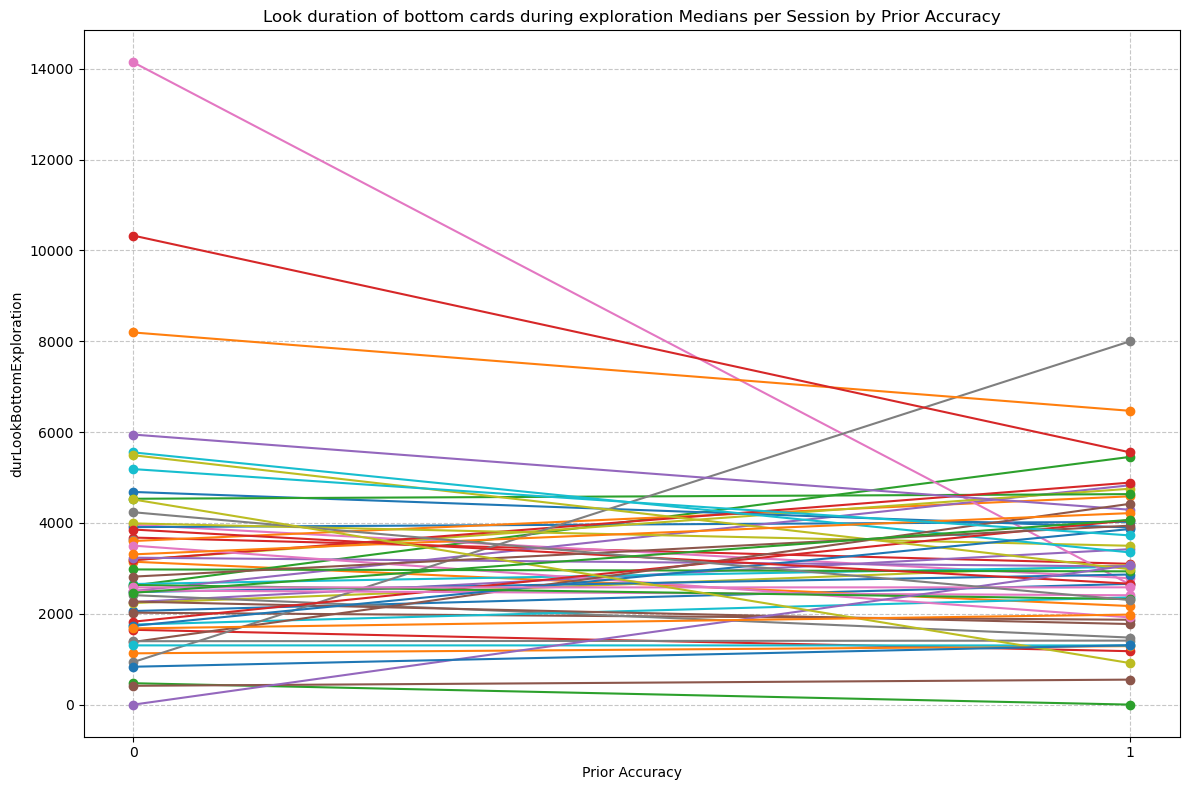

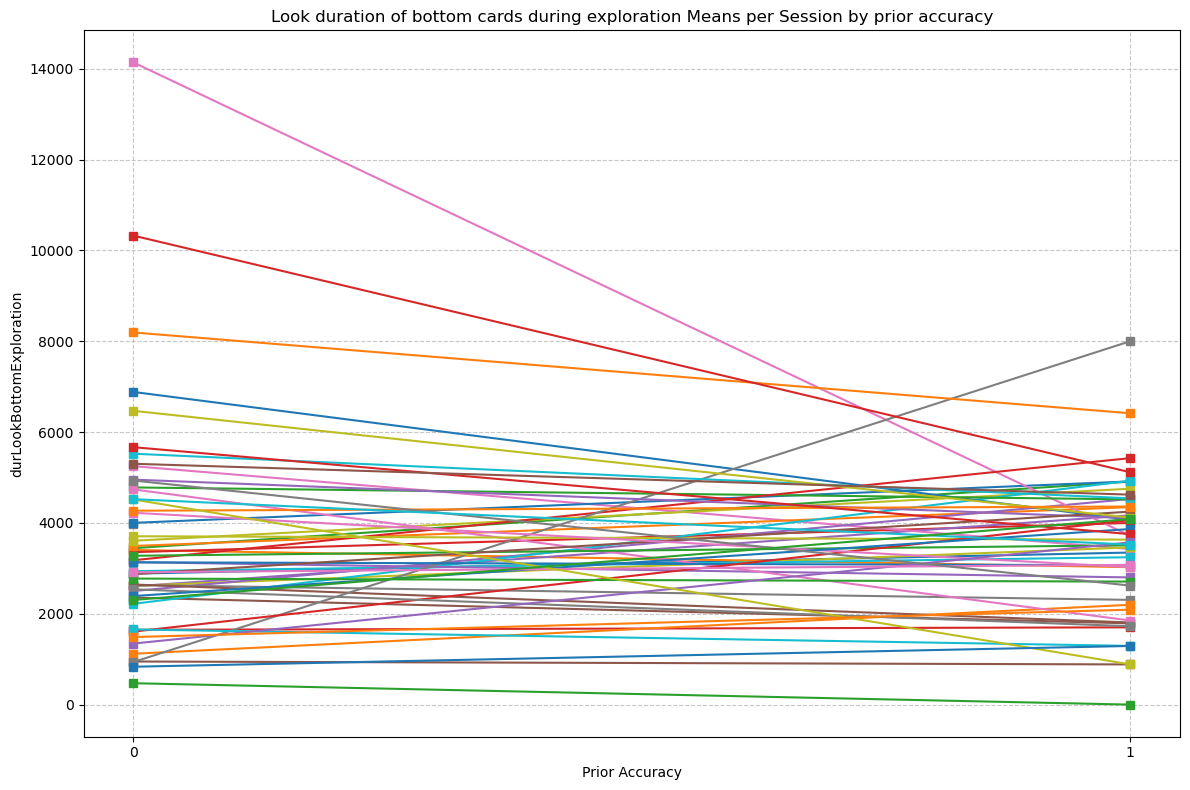

In [84]:
#look duration of bottom cards during exploration per session by prior accuracy per session

#Medians
session_look_exploration = data.groupby(['session', 'prior_accuracy'])['durLookBottomExploration'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_look_exploration.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_durLookBottom_session = session_look_exploration.loc[session][available_prior_accuracy]
        plt.plot(median_durLookBottom_session.index, median_durLookBottom_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Look duration of bottom cards during exploration Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('durLookBottomExploration')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_look_exploration_mean = data.groupby(['session', 'prior_accuracy'])['durLookBottomExploration'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_look_exploration_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_durLookBottom_session = session_look_exploration_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_durLookBottom_session.index, mean_durLookBottom_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Look duration of bottom cards during exploration Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('durLookBottomExploration')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Look Duration of Top card (decision period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 2.499419013343082e-17
Shapiro-Wilk test for 1.0: p-value = 8.077991665743807e-21
Levene's test for homogeneity of variances: p-value = 0.9617417191581836
Kruskal-Wallis test:
H-statistic: 0.11384957650137394
p-value: 0.7358033031591004
Mean LookDurInTDecision by Prior Accuracy:
prior_accuracy
0.0    1460.306050
1.0    1444.868035
Name: LookDurInTDecision, dtype: float64
SEM LookDurInTDecision by Prior Accuracy:
prior_accuracy
0.0    79.739662
1.0    75.004821
Name: LookDurInTDecision, dtype: float64


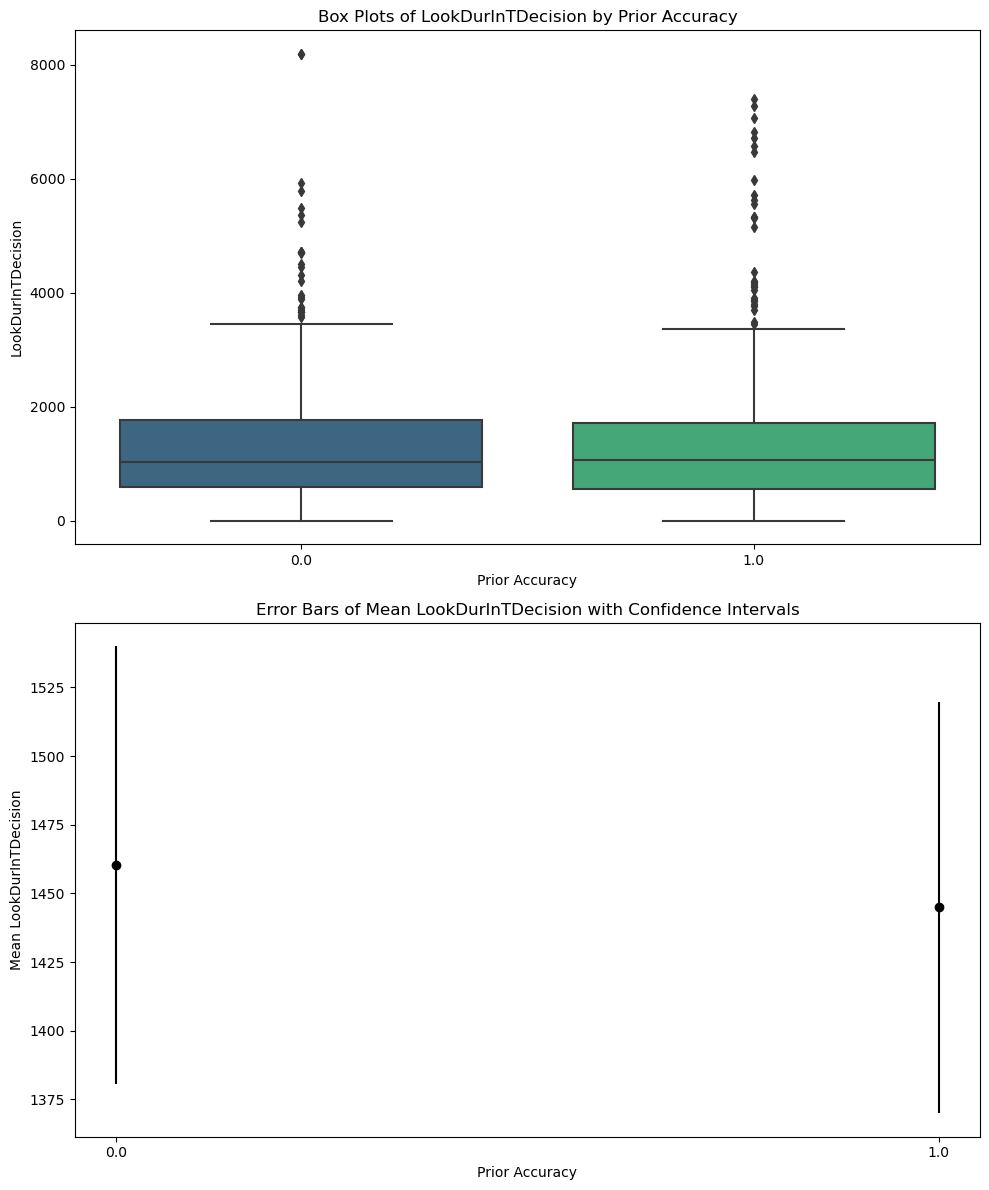

In [85]:
#Look Top Card (decision period) by Prior Accuracy

LookDurInTDecision_by_prior_accuracy = [data[data['prior_accuracy'] == level]['LookDurInTDecision'] for level in data['prior_accuracy'].unique()]
LookDurInTDecision_by_prior_accuracy = [group.dropna() for group in LookDurInTDecision_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['LookDurInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*LookDurInTDecision_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*LookDurInTDecision_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of total trial duration by accuracy
mean_LookDurInTDecision_by_prior_accuracy = data.groupby('prior_accuracy')['LookDurInTDecision'].mean()
sem_LookDurInTDecision_by_prior_accuracy = data.groupby('prior_accuracy')['LookDurInTDecision'].sem()
print("Mean LookDurInTDecision by Prior Accuracy:")
print(mean_LookDurInTDecision_by_prior_accuracy)
print("SEM LookDurInTDecision by Prior Accuracy:")
print(sem_LookDurInTDecision_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='LookDurInTDecision', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('LookDurInTDecision')
ax1.set_title('Box Plots of LookDurInTDecision by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_LookDurInTDecision_by_prior_accuracy)), mean_LookDurInTDecision_by_prior_accuracy, yerr=sem_LookDurInTDecision_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Mean LookDurInTDecision')
ax2.set_title('Error Bars of Mean LookDurInTDecision with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_LookDurInTDecision_by_prior_accuracy)))
ax2.set_xticklabels(mean_LookDurInTDecision_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

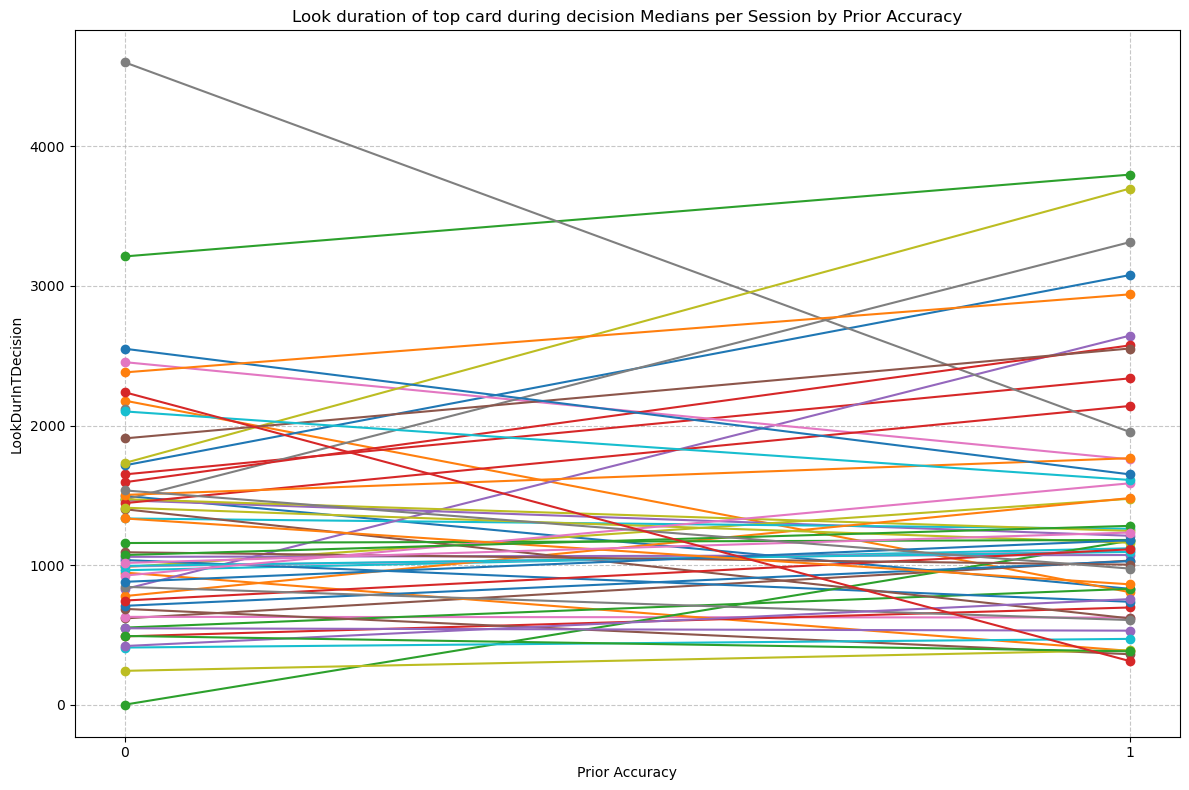

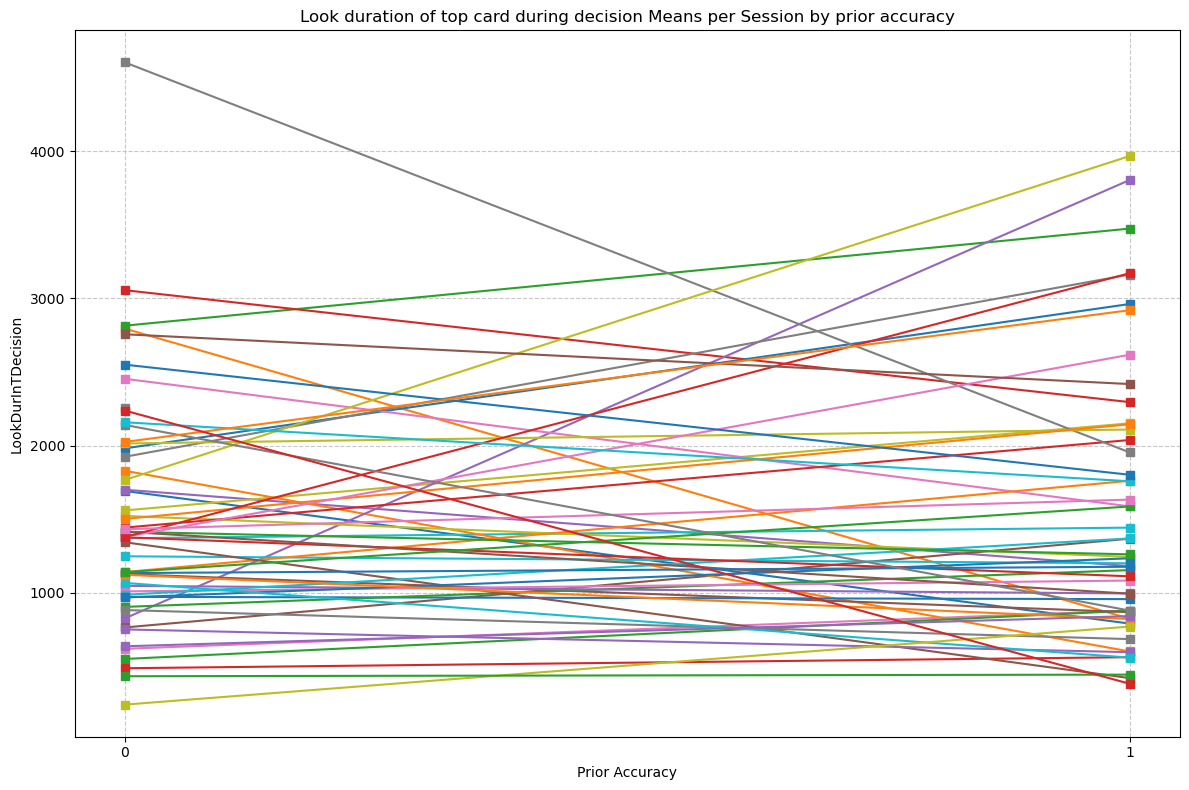

In [86]:
#look duration of top card during decision per session by prior accuracy per session

#Medians
session_look_decision = data.groupby(['session', 'prior_accuracy'])['LookDurInTDecision'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_look_decision.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_LookDurInTDecision_session = session_look_decision.loc[session][available_prior_accuracy]
        plt.plot(median_LookDurInTDecision_session.index, median_LookDurInTDecision_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Look duration of top card during decision Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('LookDurInTDecision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_look_decision_mean = data.groupby(['session', 'prior_accuracy'])['LookDurInTDecision'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_look_decision_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_LookDurInTDecision_session = session_look_decision_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_LookDurInTDecision_session.index, mean_LookDurInTDecision_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Look duration of top card during decision Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('LookDurInTDecision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Total Number of fixations vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.2338385101754815e-14
Shapiro-Wilk test for 1.0: p-value = 2.0321907347537708e-11
Levene's test for homogeneity of variances: p-value = 0.30255974095011207
Kruskal-Wallis test:
H-statistic: 0.05490153369140947
p-value: 0.8147437307553598
Mean FixNb by Prior Accuracy:
prior_accuracy
0.0    15.629893
1.0    15.495601
Name: FixNb, dtype: float64
SEM FixNb by Prior Accuracy:
prior_accuracy
0.0    0.493315
1.0    0.439051
Name: FixNb, dtype: float64


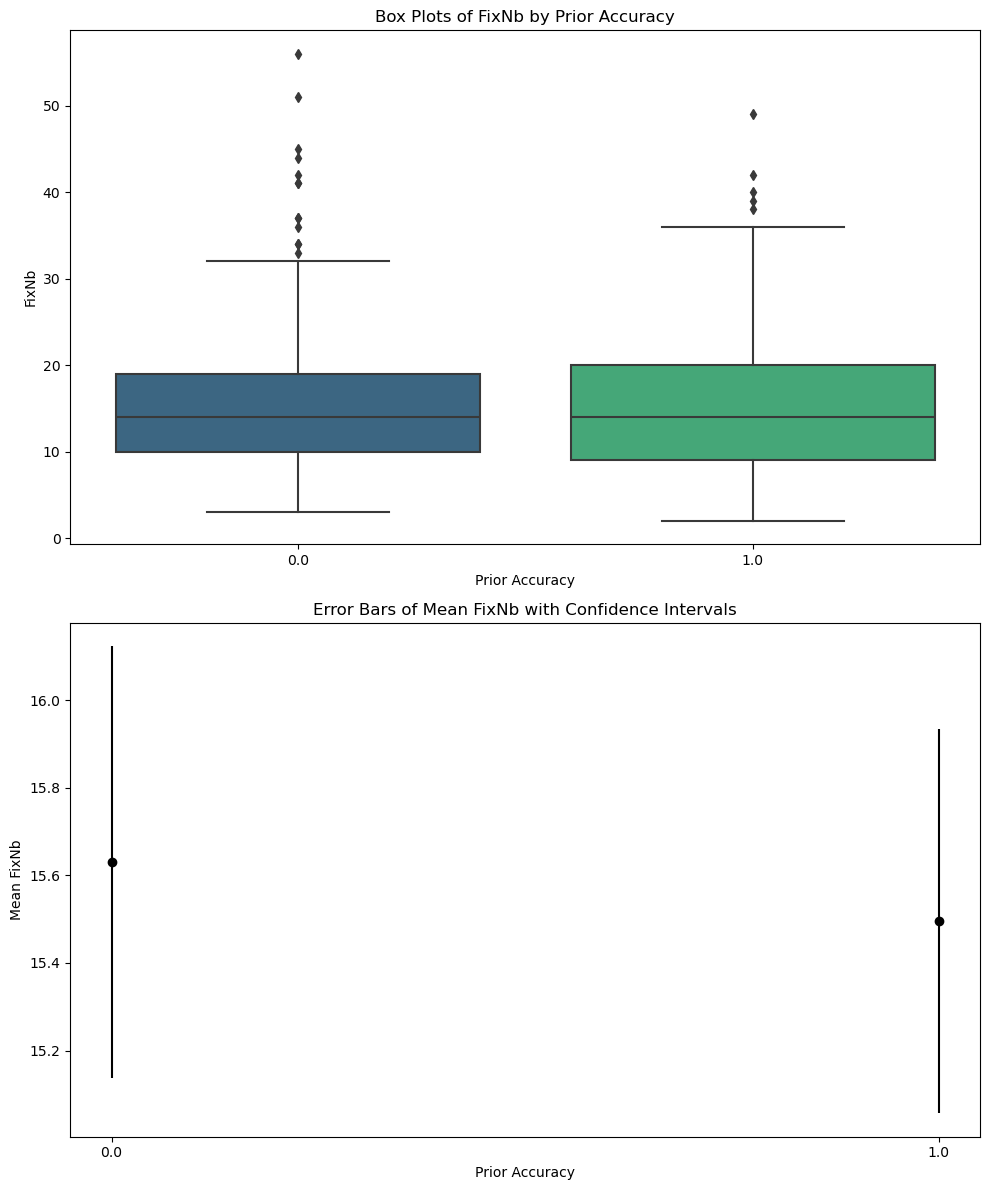

In [87]:
#Fixations by Prior Accuracy

FixNb_by_prior_accuracy = [data[data['prior_accuracy'] == level]['FixNb'] for level in data['prior_accuracy'].unique()]
FixNb_by_prior_accuracy = [group.dropna() for group in FixNb_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['FixNb']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*FixNb_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*FixNb_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of FixNb by accuracy
mean_FixNb_by_prior_accuracy = data.groupby('prior_accuracy')['FixNb'].mean()
sem_FixNb_by_prior_accuracy = data.groupby('prior_accuracy')['FixNb'].sem()
print("Mean FixNb by Prior Accuracy:")
print(mean_FixNb_by_prior_accuracy)
print("SEM FixNb by Prior Accuracy:")
print(sem_FixNb_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='FixNb', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('FixNb')
ax1.set_title('Box Plots of FixNb by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_FixNb_by_prior_accuracy)), mean_FixNb_by_prior_accuracy, yerr=sem_FixNb_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Mean FixNb')
ax2.set_title('Error Bars of Mean FixNb with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_FixNb_by_prior_accuracy)))
ax2.set_xticklabels(mean_FixNb_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

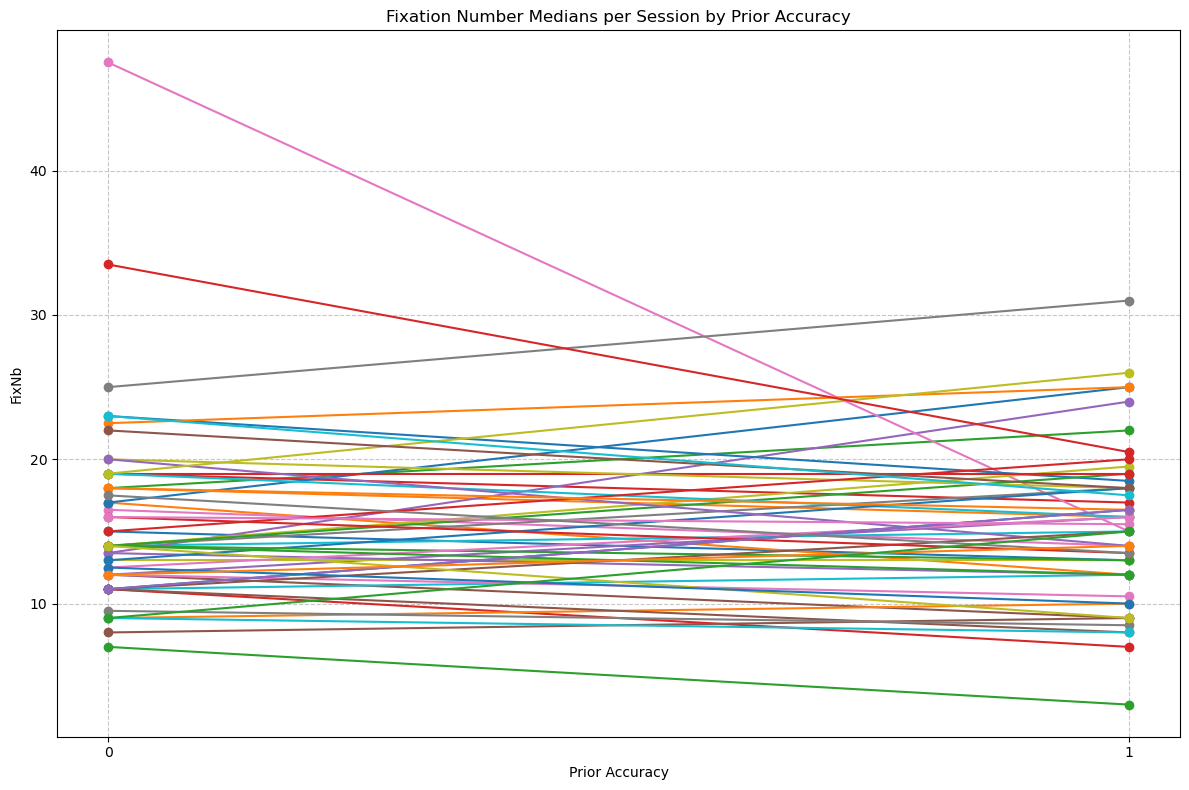

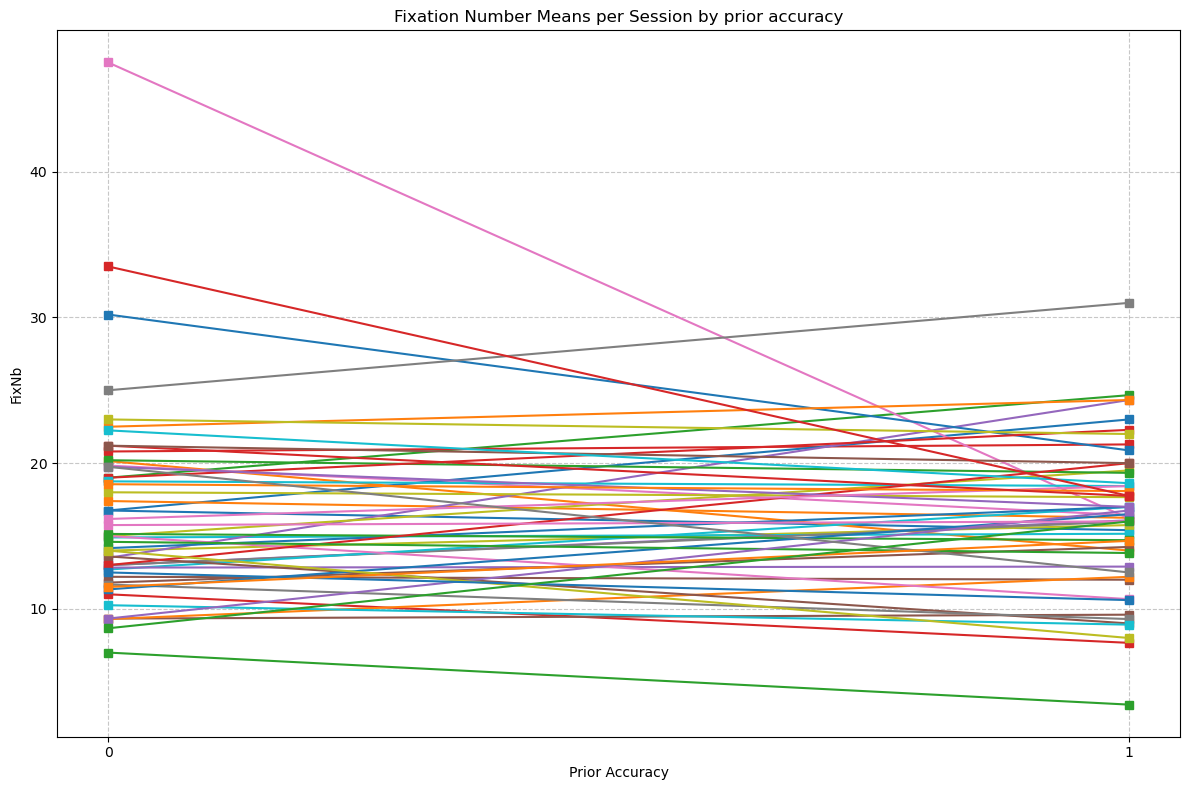

In [88]:
# Total number of fixations per session by prior accuracy per session

#Medians
session_FixNb = data.groupby(['session', 'prior_accuracy'])['FixNb'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_FixNb.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixNb_session = session_FixNb.loc[session][available_prior_accuracy]
        plt.plot(median_FixNb_session.index, median_FixNb_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Fixation Number Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('FixNb')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_FixNb_mean = data.groupby(['session', 'prior_accuracy'])['FixNb'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_FixNb_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_FixNb_session = session_FixNb_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_FixNb_session.index, mean_FixNb_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Fixation Number Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('FixNb')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Number of fixations in exploration and decision periods vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.1705655791985487e-17
Shapiro-Wilk test for 1.0: p-value = 2.2893515144387345e-13
Levene's test for homogeneity of variances: p-value = 0.7672621790807257
Kruskal-Wallis test:
H-statistic: 0.007796367016026823
p-value: 0.9296405926619011
Shapiro-Wilk test for 0.0: p-value = 1.1149790252667368e-17
Shapiro-Wilk test for 1.0: p-value = 1.765765665901861e-21
Levene's test for homogeneity of variances: p-value = 0.9314530367922357
Kruskal-Wallis test:
H-statistic: 0.02191103368628386
p-value: 0.882324016599186
Mean Fixation Number during Exploration by Prior Accuracy:
[10.56227758 10.42815249]
SEM Fixation Number during Exploration by Prior Accuracy:
[0.4419701  0.36376182]
Mean Fixation Number during Decision by Prior Accuracy:
[5.06761566 5.06744868]
SEM Fixation Number during Decision by Prior Accuracy:
[0.20348125 0.19027251]


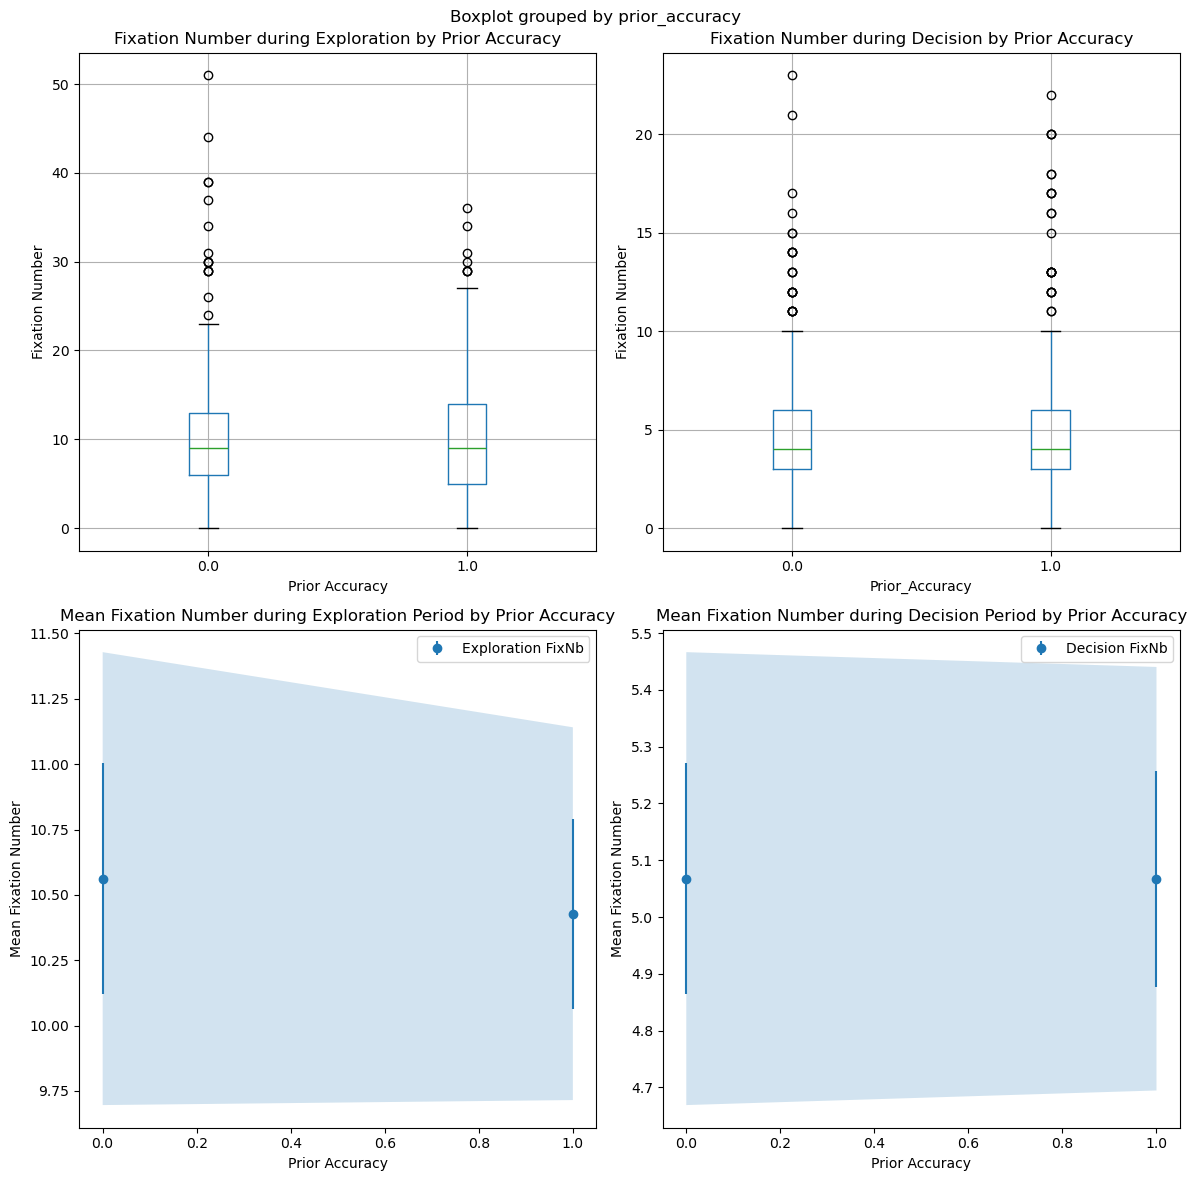

In [89]:
#Fixation Number exploration vs. decision periods by prior accuracy

FixNbExploration_by_prior_accuracy = [data[data['prior_accuracy'] == level]['FixNbExplorationPeriod'] for level in data['prior_accuracy'].unique()]
FixNbExploration_by_prior_accuracy = [group.dropna() for group in FixNbExploration_by_prior_accuracy]

FixNbDecision_by_prior_accuracy = [data[data['prior_accuracy'] == level]['FixNbDecisionPeriod'] for level in data['prior_accuracy'].unique()]
FixNbDecision_by_prior_accuracy = [group.dropna() for group in FixNbDecision_by_prior_accuracy]

# Shapiro-Wilk test for normality - Exploration
for group_name, group_data in data.groupby('prior_accuracy')['FixNbExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances - Exploration
stat, p = levene(*FixNbExploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test - Exploration
H, p = kruskal(*FixNbExploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Shapiro-Wilk test for normality - Decision
for group_name, group_data in data.groupby('prior_accuracy')['FixNbDecisionPeriod']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances - Decision
stat, p = levene(*FixNbDecision_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test - Decision
H, p = kruskal(*FixNbDecision_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of duration of exploration period by prior accuracy
mean_exp_FixNb_by_prior_accuracy = data.groupby('prior_accuracy')['FixNbExplorationPeriod'].mean().values
sem_exp_FixNb_by_prior_accuracy = data.groupby('prior_accuracy')['FixNbExplorationPeriod'].sem().values

# Confidence intervals for exploration
FixNbexploration_conf_intervals = 1.96 * sem_exp_FixNb_by_prior_accuracy  

print("Mean Fixation Number during Exploration by Prior Accuracy:")
print(mean_exp_FixNb_by_prior_accuracy)
print("SEM Fixation Number during Exploration by Prior Accuracy:")
print(sem_exp_FixNb_by_prior_accuracy)

# Mean and SEM of duration of decision period by prior accuracy
mean_dec_FixNb_by_prior_accuracy = data.groupby('prior_accuracy')['FixNbDecisionPeriod'].mean().values
sem_dec_FixNb_by_prior_accuracy = data.groupby('prior_accuracy')['FixNbDecisionPeriod'].sem().values

# Confidence intervals for decision 
FixNbdecision_conf_intervals = 1.96 * sem_dec_FixNb_by_prior_accuracy  

print("Mean Fixation Number during Decision by Prior Accuracy:")
print(mean_dec_FixNb_by_prior_accuracy)
print("SEM Fixation Number during Decision by Prior Accuracy:")
print(sem_dec_FixNb_by_prior_accuracy)

# Plots
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))

# Exploration Period Boxplot
data.boxplot(column='FixNbExplorationPeriod', by='prior_accuracy', ax=axs[0, 0])
axs[0, 0].set_title('Fixation Number during Exploration by Prior Accuracy')
axs[0, 0].set_xlabel('Prior Accuracy')
axs[0, 0].set_ylabel('Fixation Number')

# Decision Period Boxplot
data.boxplot(column='FixNbDecisionPeriod', by='prior_accuracy', ax=axs[0, 1])
axs[0, 1].set_title('Fixation Number during Decision by Prior Accuracy')
axs[0, 1].set_xlabel('Prior_Accuracy')
axs[0, 1].set_ylabel('Fixation Number')

# Error bars with confidence intervals
axs[1, 0].errorbar(np.arange(len(mean_exp_FixNb_by_prior_accuracy)), mean_exp_FixNb_by_prior_accuracy, yerr=sem_exp_FixNb_by_prior_accuracy, fmt='o', label='Exploration FixNb')
axs[1, 0].fill_between(np.arange(len(mean_exp_FixNb_by_prior_accuracy)), mean_exp_FixNb_by_prior_accuracy - FixNbexploration_conf_intervals, mean_exp_FixNb_by_prior_accuracy + FixNbexploration_conf_intervals, alpha=0.2)
axs[1, 0].set_xlabel('Prior Accuracy')
axs[1, 0].set_ylabel('Mean Fixation Number')
axs[1, 0].set_title('Mean Fixation Number during Exploration Period by Prior Accuracy')
axs[1, 0].legend()

axs[1, 1].errorbar(np.arange(len(mean_dec_FixNb_by_prior_accuracy)), mean_dec_FixNb_by_prior_accuracy, yerr=sem_dec_FixNb_by_prior_accuracy, fmt='o', label='Decision FixNb')
axs[1, 1].fill_between(np.arange(len(mean_dec_FixNb_by_prior_accuracy)), mean_dec_FixNb_by_prior_accuracy - FixNbdecision_conf_intervals, mean_dec_FixNb_by_prior_accuracy + FixNbdecision_conf_intervals, alpha=0.2)
axs[1, 1].set_xlabel('Prior Accuracy')
axs[1, 1].set_ylabel('Mean Fixation Number')
axs[1, 1].set_title('Mean Fixation Number during Decision Period by Prior Accuracy')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

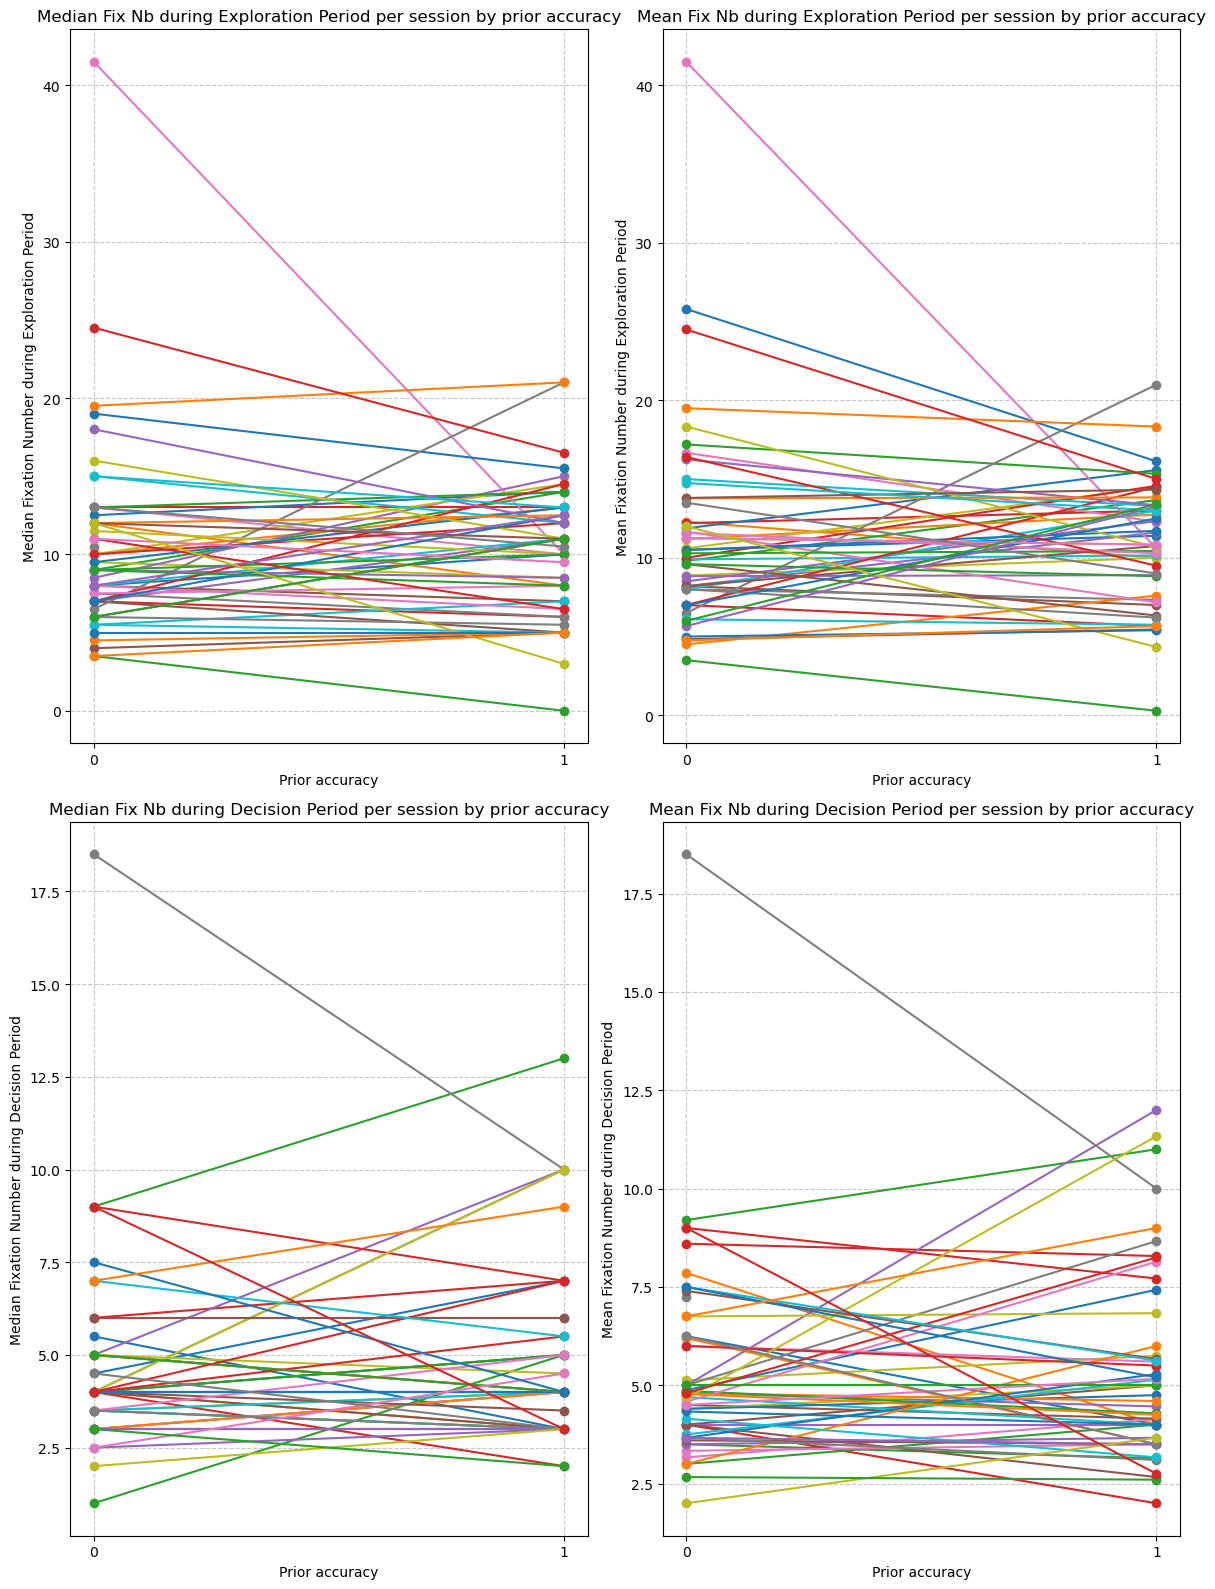

In [90]:
# Fixation number for both exploration and decision periods vs. prior accuracy per session

# Median Fixation Number during Exploration Period per session by prior accuracy 
FixNbExplorationPeriod_per_trial_prior_accuracy = data.groupby(['session', 'trialno', 'prior_accuracy'])['FixNbExplorationPeriod'].sum().reset_index()
FixNbExplorationPeriod_per_trial_prior_accuracy.dropna(inplace=True)
median_FixNbExplorationPeriod_per_session_prior_accuracy = FixNbExplorationPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['FixNbExplorationPeriod'].median().unstack()

plt.figure(figsize=(12, 16))

all_sessions = median_FixNbExplorationPeriod_per_session_prior_accuracy.index

plt.subplot(2, 2, 1)
for session in all_sessions:
    session_data = median_FixNbExplorationPeriod_per_session_prior_accuracy.loc[session].dropna()
    plt.plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
plt.title('Median Fix Nb during Exploration Period per session by prior accuracy')
plt.xlabel('Prior accuracy')
plt.ylabel('Median Fixation Number during Exploration Period')
plt.xticks([0, 1]) 
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()

# Mean Fixation Number during Exploration Period  per session by prior accuracy
mean_FixNbExplorationPeriod_per_session_prior_accuracy = FixNbExplorationPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['FixNbExplorationPeriod'].mean().unstack()

plt.subplot(2, 2, 2)
for session in all_sessions:
    session_data = mean_FixNbExplorationPeriod_per_session_prior_accuracy.loc[session].dropna()
    plt.plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
plt.title('Mean Fix Nb during Exploration Period per session by prior accuracy')
plt.xlabel('Prior accuracy')
plt.ylabel('Mean Fixation Number during Exploration Period')
plt.xticks([0, 1]) 
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()

# Median Fixation Number during Decision Period  per session by prior accuracy
FixNbDecisionPeriod_per_trial_prior_accuracy = data.groupby(['session', 'trialno', 'prior_accuracy'])['FixNbDecisionPeriod'].sum().reset_index()
FixNbDecisionPeriod_per_trial_prior_accuracy.dropna(inplace=True)
median_FixNbDecisionPeriod_per_session_prior_accuracy = FixNbDecisionPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['FixNbDecisionPeriod'].median().unstack()

plt.subplot(2, 2, 3)
for session in all_sessions:
    session_data = median_FixNbDecisionPeriod_per_session_prior_accuracy.loc[session].dropna()
    plt.plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
plt.title('Median Fix Nb during Decision Period per session by prior accuracy')
plt.xlabel('Prior accuracy')
plt.ylabel('Median Fixation Number during Decision Period')
plt.xticks([0, 1]) 
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()

# Mean Fixation Number during Decision Period  per session by prior accuracy
mean_FixNbDecisionPeriod_per_session_prior_accuracy = FixNbDecisionPeriod_per_trial_prior_accuracy.groupby(['session', 'prior_accuracy'])['FixNbDecisionPeriod'].mean().unstack()

plt.subplot(2, 2, 4)
for session in all_sessions:
    session_data = mean_FixNbDecisionPeriod_per_session_prior_accuracy.loc[session].dropna()
    plt.plot(session_data.index, session_data, marker='o', linestyle='-', label=f'Session {session}')
plt.title('Mean Fix Nb during Decision Period per session by prior accuracy')
plt.xlabel('Prior accuracy')
plt.ylabel('Mean Fixation Number during Decision Period')
plt.xticks([0, 1]) 
plt.grid(True, linestyle='--', alpha=0.7)
#plt.legend()

plt.tight_layout()
plt.show()

### Number of fixations of bottom cards during exploration vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 3.136232073649931e-17
Shapiro-Wilk test for 1.0: p-value = 1.2642792282421602e-13
Levene's test for homogeneity of variances: p-value = 0.8437801403021188
Kruskal-Wallis test:
H-statistic: 0.019960097833761778
p-value: 0.8876485826571692
Mean FixNbInBottomExploration by Prior Accuracy:
prior_accuracy
0.0    8.843416
1.0    8.668622
Name: FixNbInBottomExploration, dtype: float64
SEM FixNbInBottomExploration by Prior Accuracy:
prior_accuracy
0.0    0.441423
1.0    0.361312
Name: FixNbInBottomExploration, dtype: float64


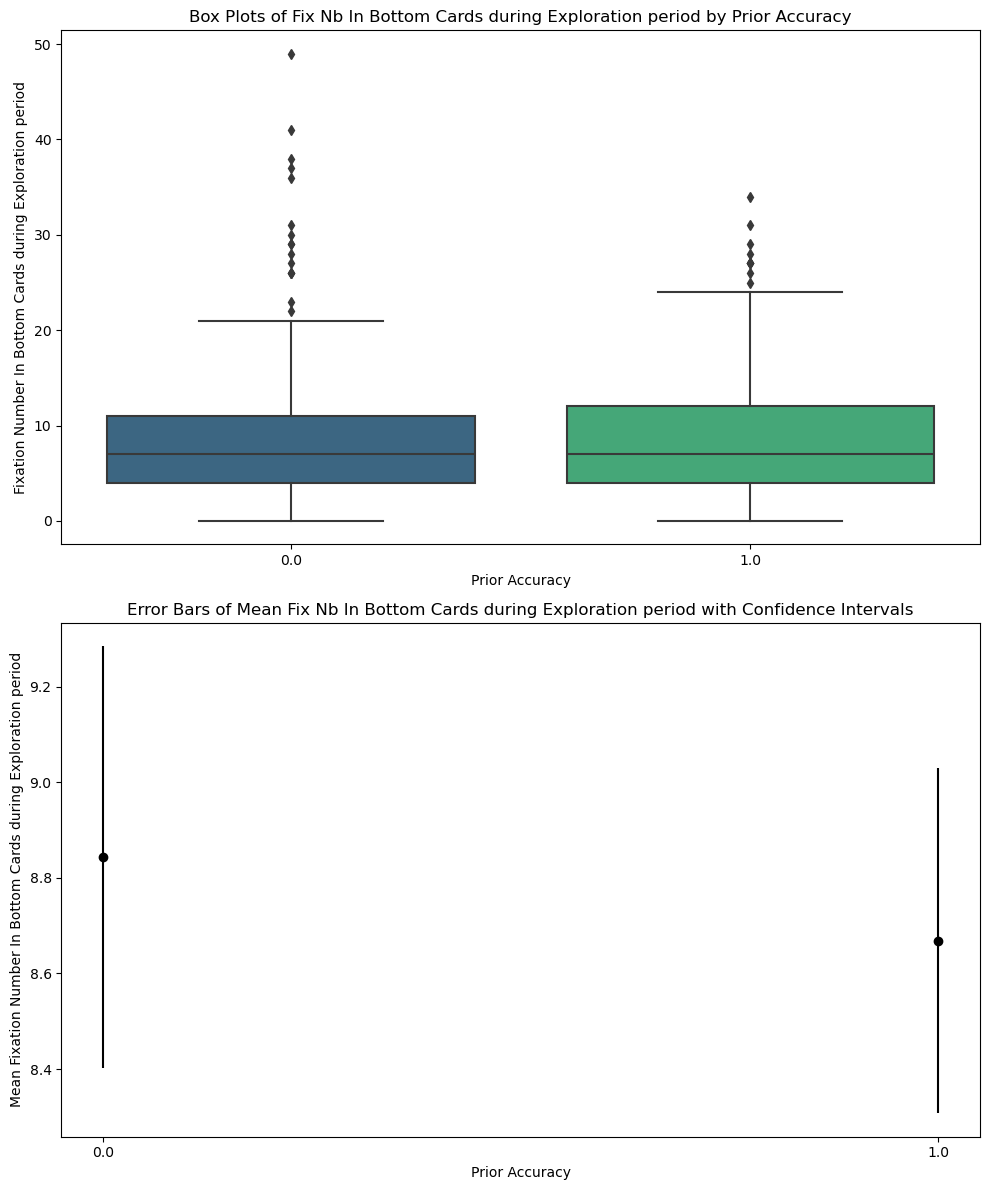

In [91]:
# Number of Fixations Bottom cards (exploration period) by Prior Accuracy

FixNbInBottomExploration_by_prior_accuracy = [data[data['prior_accuracy'] == level]['FixNbInBottomExploration'] for level in data['prior_accuracy'].unique()]
FixNbInBottomExploration_by_prior_accuracy = [group.dropna() for group in FixNbInBottomExploration_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['FixNbInBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*FixNbInBottomExploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*FixNbInBottomExploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of Fixation duration  of top card (decision period) by accuracy
mean_FixNbInBottomExploration_by_prior_accuracy = data.groupby('prior_accuracy')['FixNbInBottomExploration'].mean()
sem_FixNbInBottomExploration_by_prior_accuracy = data.groupby('prior_accuracy')['FixNbInBottomExploration'].sem()
print("Mean FixNbInBottomExploration by Prior Accuracy:")
print(mean_FixNbInBottomExploration_by_prior_accuracy)
print("SEM FixNbInBottomExploration by Prior Accuracy:")
print(sem_FixNbInBottomExploration_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='FixNbInBottomExploration', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Fixation Number In Bottom Cards during Exploration period')
ax1.set_title('Box Plots of Fix Nb In Bottom Cards during Exploration period by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_FixNbInBottomExploration_by_prior_accuracy)), mean_FixNbInBottomExploration_by_prior_accuracy, yerr=sem_FixNbInBottomExploration_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Mean Fixation Number In Bottom Cards during Exploration period')
ax2.set_title('Error Bars of Mean Fix Nb In Bottom Cards during Exploration period with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_FixNbInBottomExploration_by_prior_accuracy)))
ax2.set_xticklabels(mean_FixNbInBottomExploration_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

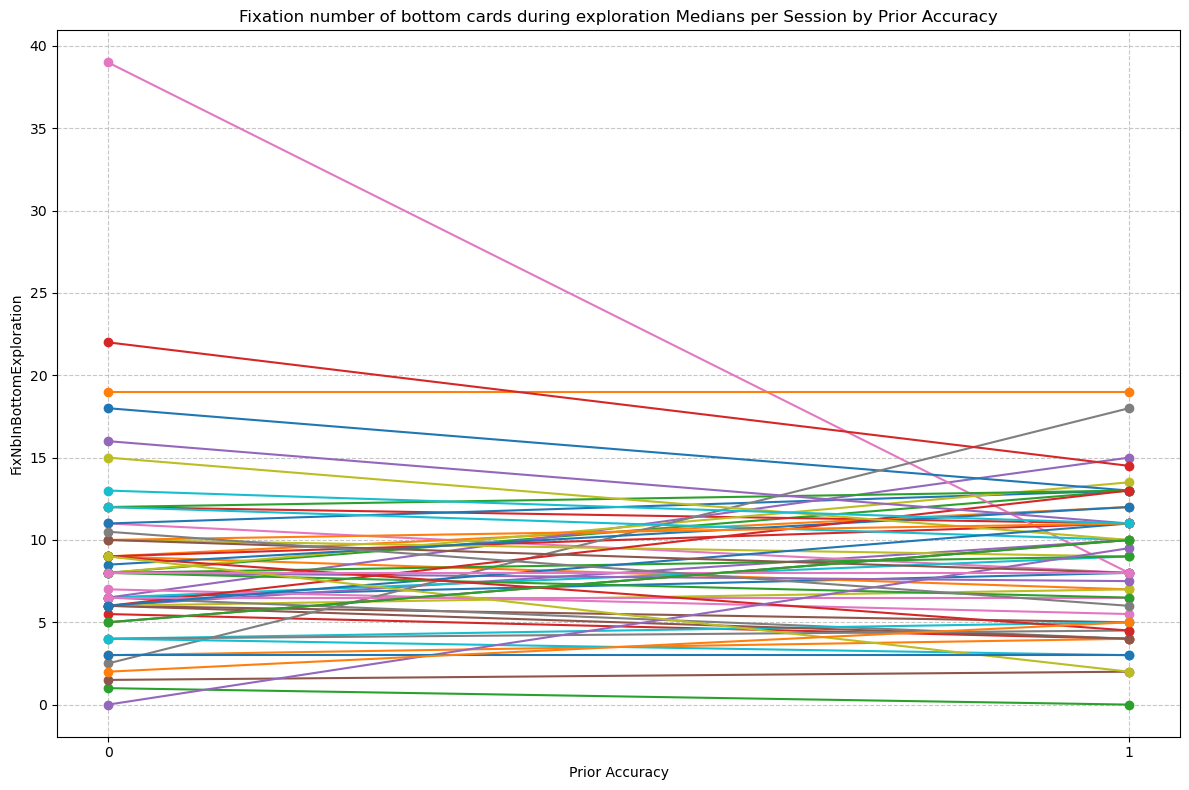

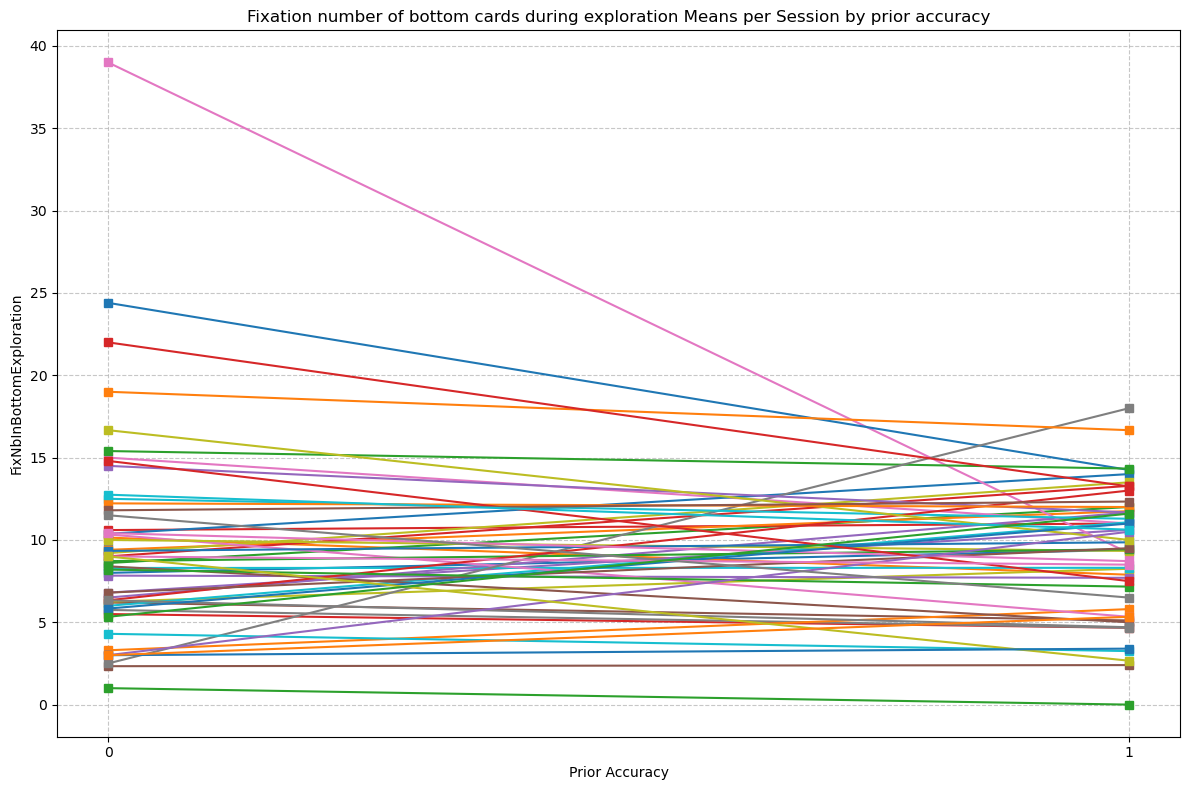

In [92]:
#Fixation Number of bottom cards during exploration per session by prior accuracy per session

#Medians
session_fix_exploration = data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_fix_exploration.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixNbInBottomExploration_session = session_fix_exploration.loc[session][available_prior_accuracy]
        plt.plot(median_FixNbInBottomExploration_session.index, median_FixNbInBottomExploration_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Fixation number of bottom cards during exploration Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('FixNbInBottomExploration')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_fix_exploration_mean = data.groupby(['session', 'prior_accuracy'])['FixNbInBottomExploration'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_fix_exploration_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_FixNbInBottomExploration_session = session_fix_exploration_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_FixNbInBottomExploration_session.index, mean_FixNbInBottomExploration_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Fixation number of bottom cards during exploration Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('FixNbInBottomExploration')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Number of fixations of top card (decision period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.9671477577675026e-18
Shapiro-Wilk test for 1.0: p-value = 1.3177953686031024e-21
Levene's test for homogeneity of variances: p-value = 0.9720133497629059
Kruskal-Wallis test:
H-statistic: 0.1489153900536974
p-value: 0.6995740124843579
Mean FixNbInTDecision by Prior Accuracy:
prior_accuracy
0.0    3.672598
1.0    3.627566
Name: FixNbInTDecision, dtype: float64
SEM FixNbInTDecision by Prior Accuracy:
prior_accuracy
0.0    0.193826
1.0    0.178442
Name: FixNbInTDecision, dtype: float64


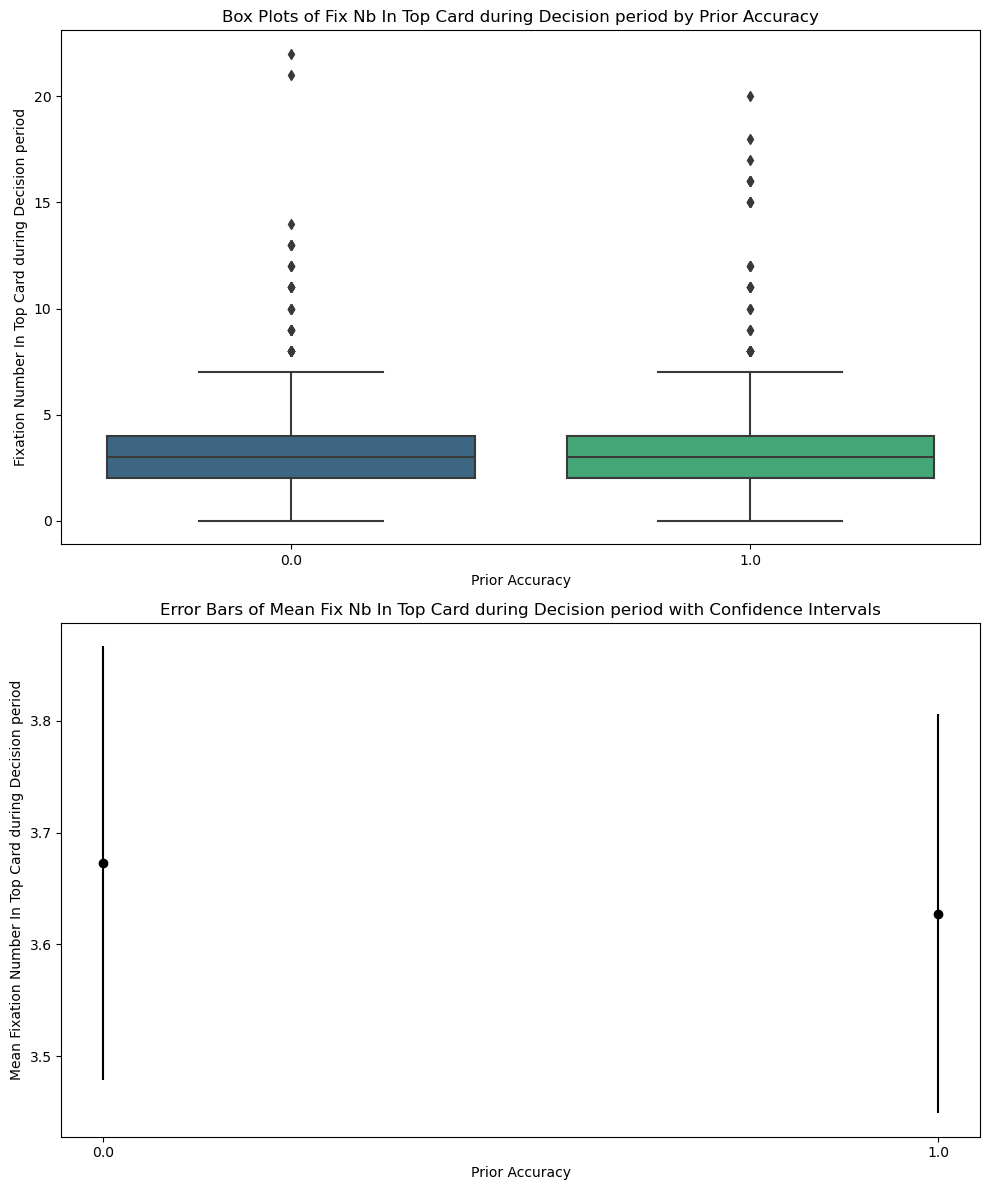

In [93]:
# Number of Fixations Top Card (decision period) by Prior Accuracy

FixNbInTDecision_by_prior_accuracy = [data[data['prior_accuracy'] == level]['FixNbInTDecision'] for level in data['prior_accuracy'].unique()]
FixNbInTDecision_by_prior_accuracy = [group.dropna() for group in FixNbInTDecision_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['FixNbInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*FixNbInTDecision_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*FixNbInTDecision_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of Fixation duration  of top card (decision period) by accuracy
mean_FixNbInTDecision_by_prior_accuracy = data.groupby('prior_accuracy')['FixNbInTDecision'].mean()
sem_FixNbInTDecision_by_prior_accuracy = data.groupby('prior_accuracy')['FixNbInTDecision'].sem()
print("Mean FixNbInTDecision by Prior Accuracy:")
print(mean_FixNbInTDecision_by_prior_accuracy)
print("SEM FixNbInTDecision by Prior Accuracy:")
print(sem_FixNbInTDecision_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='FixNbInTDecision', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Fixation Number In Top Card during Decision period')
ax1.set_title('Box Plots of Fix Nb In Top Card during Decision period by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_FixNbInTDecision_by_prior_accuracy)), mean_FixNbInTDecision_by_prior_accuracy, yerr=sem_FixNbInTDecision_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Mean Fixation Number In Top Card during Decision period')
ax2.set_title('Error Bars of Mean Fix Nb In Top Card during Decision period with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_FixNbInTDecision_by_prior_accuracy)))
ax2.set_xticklabels(mean_FixNbInTDecision_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

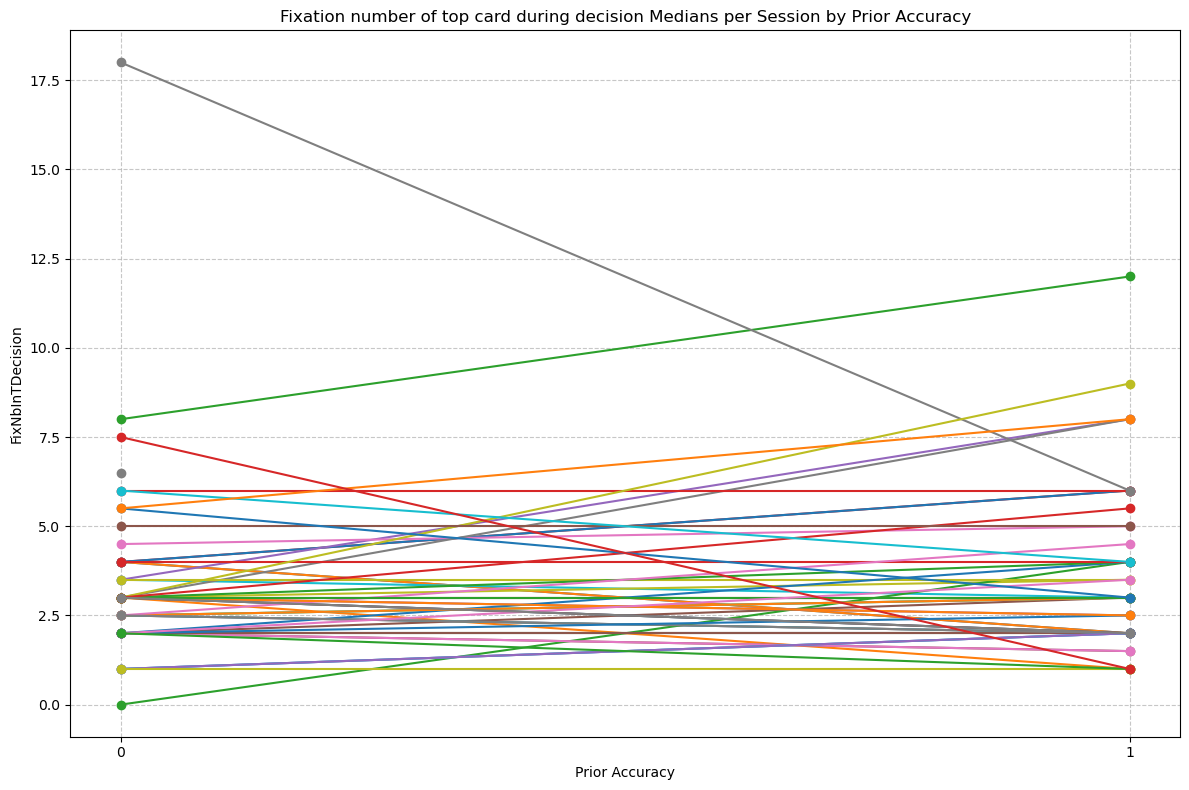

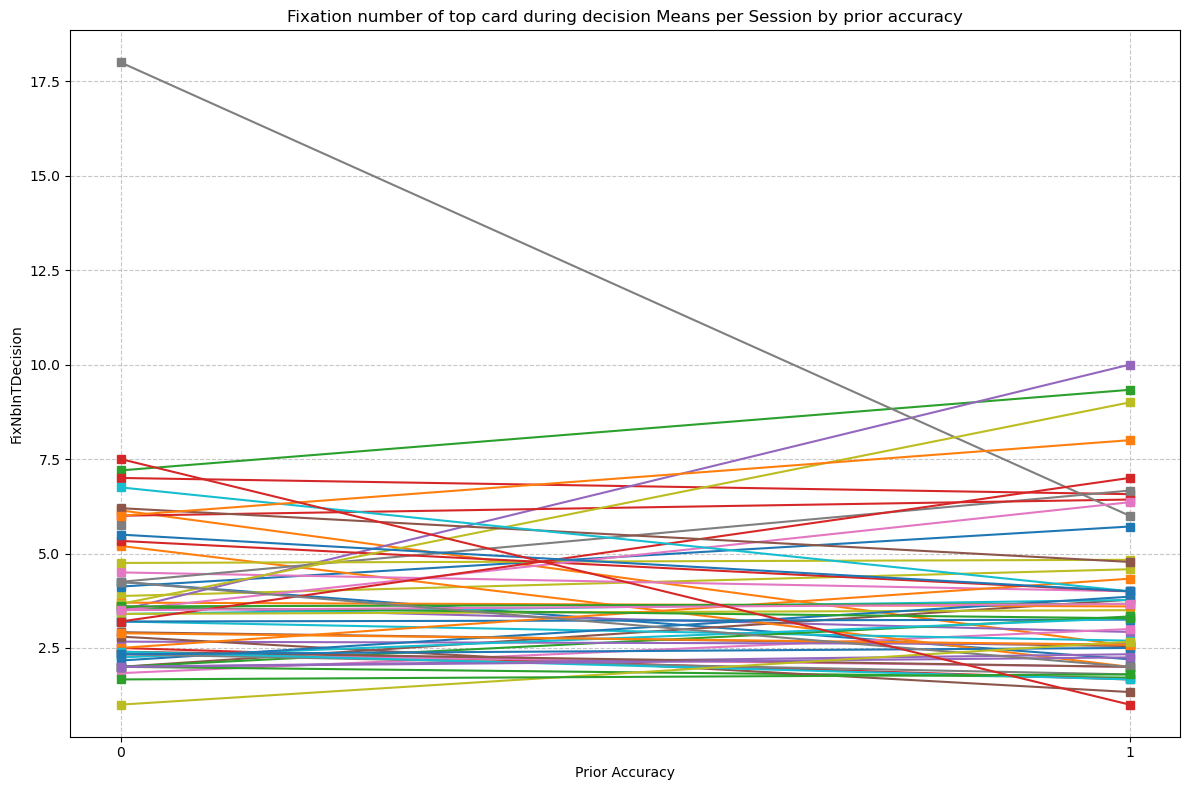

In [94]:
#Fixation Number of top card during decision per session by prior accuracy per session

#Medians
session_fix_decision = data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_fix_decision.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixNbInTDecision_session = session_fix_decision.loc[session][available_prior_accuracy]
        plt.plot(median_FixNbInTDecision_session.index, median_FixNbInTDecision_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Fixation number of top card during decision Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('FixNbInTDecision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_fix_decision_mean = data.groupby(['session', 'prior_accuracy'])['FixNbInTDecision'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_fix_decision_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_FixNbInTDecision_session = session_fix_decision_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_FixNbInTDecision_session.index, mean_FixNbInTDecision_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Fixation number of top card during decision Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('FixNbInTDecision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Fixation Duration of Top Card (Decision Period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 4.034482179329277e-17
Shapiro-Wilk test for 1.0: p-value = 7.112687871321248e-21
Levene's test for homogeneity of variances: p-value = 0.9700388581501769
Kruskal-Wallis test:
H-statistic: 0.05884547476827337
p-value: 0.8083301081019716
Mean FixDurInTDecision by Prior Accuracy:
prior_accuracy
0.0    1294.377224
1.0    1293.043988
Name: FixDurInTDecision, dtype: float64
SEM FixDurInTDecision by Prior Accuracy:
prior_accuracy
0.0    69.716112
1.0    66.695232
Name: FixDurInTDecision, dtype: float64


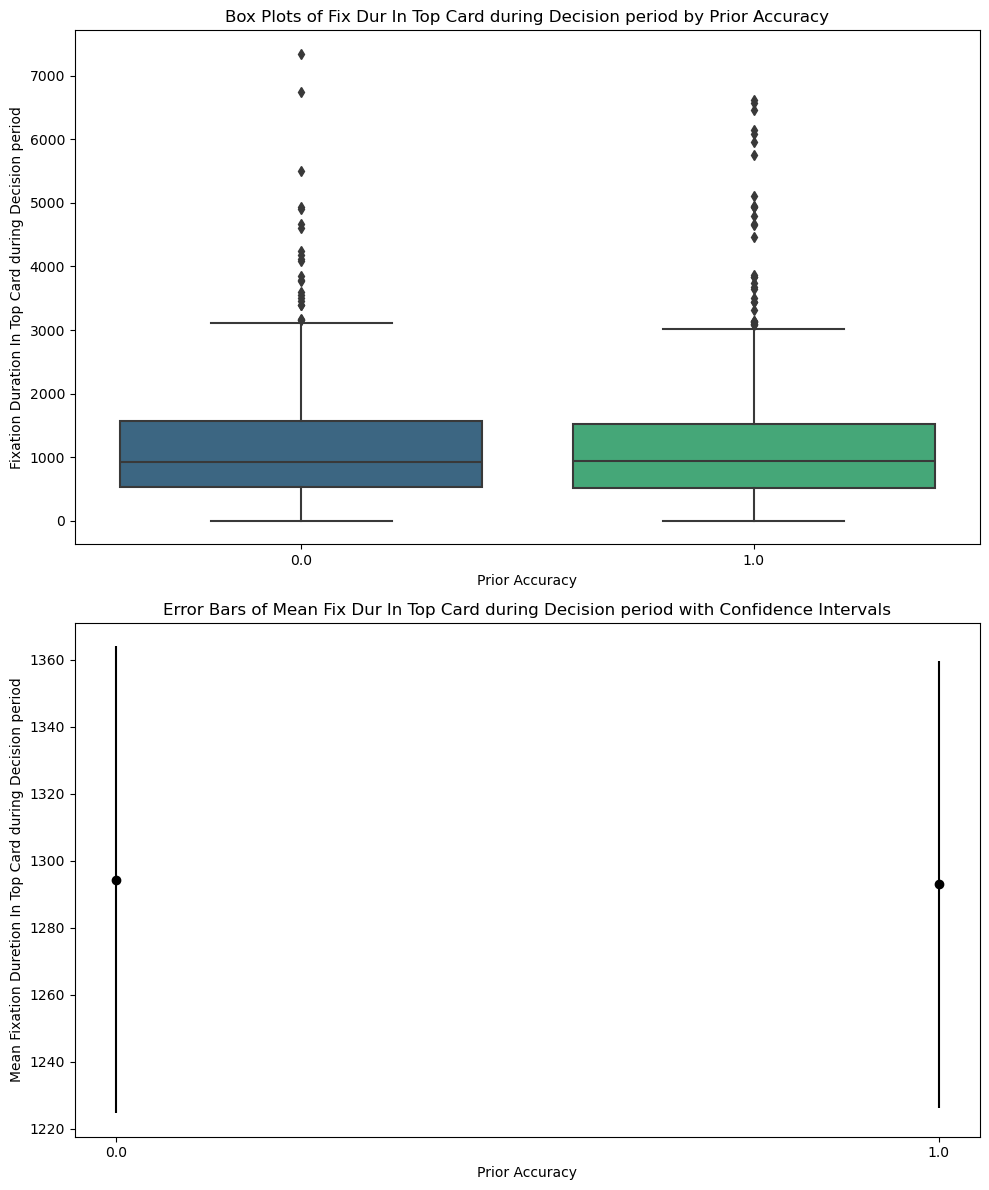

In [95]:
#Fixation Duration Top Card (decision period) by Prior Accuracy

FixDurInTDecision_by_prior_accuracy = [data[data['prior_accuracy'] == level]['FixDurInTDecision'] for level in data['prior_accuracy'].unique()]
FixDurInTDecision_by_prior_accuracy = [group.dropna() for group in FixDurInTDecision_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['FixDurInTDecision']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*FixDurInTDecision_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*FixDurInTDecision_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of Fixation duration  of top card (decision period) by accuracy
mean_FixDurInTDecision_by_prior_accuracy = data.groupby('prior_accuracy')['FixDurInTDecision'].mean()
sem_FixDurInTDecision_by_prior_accuracy = data.groupby('prior_accuracy')['FixDurInTDecision'].sem()
print("Mean FixDurInTDecision by Prior Accuracy:")
print(mean_FixDurInTDecision_by_prior_accuracy)
print("SEM FixDurInTDecision by Prior Accuracy:")
print(sem_FixDurInTDecision_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='FixDurInTDecision', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Fixation Duration In Top Card during Decision period')
ax1.set_title('Box Plots of Fix Dur In Top Card during Decision period by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_FixDurInTDecision_by_prior_accuracy)), mean_FixDurInTDecision_by_prior_accuracy, yerr=sem_FixDurInTDecision_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Mean Fixation Duretion In Top Card during Decision period')
ax2.set_title('Error Bars of Mean Fix Dur In Top Card during Decision period with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_LookDurInTDecision_by_prior_accuracy)))
ax2.set_xticklabels(mean_LookDurInTDecision_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

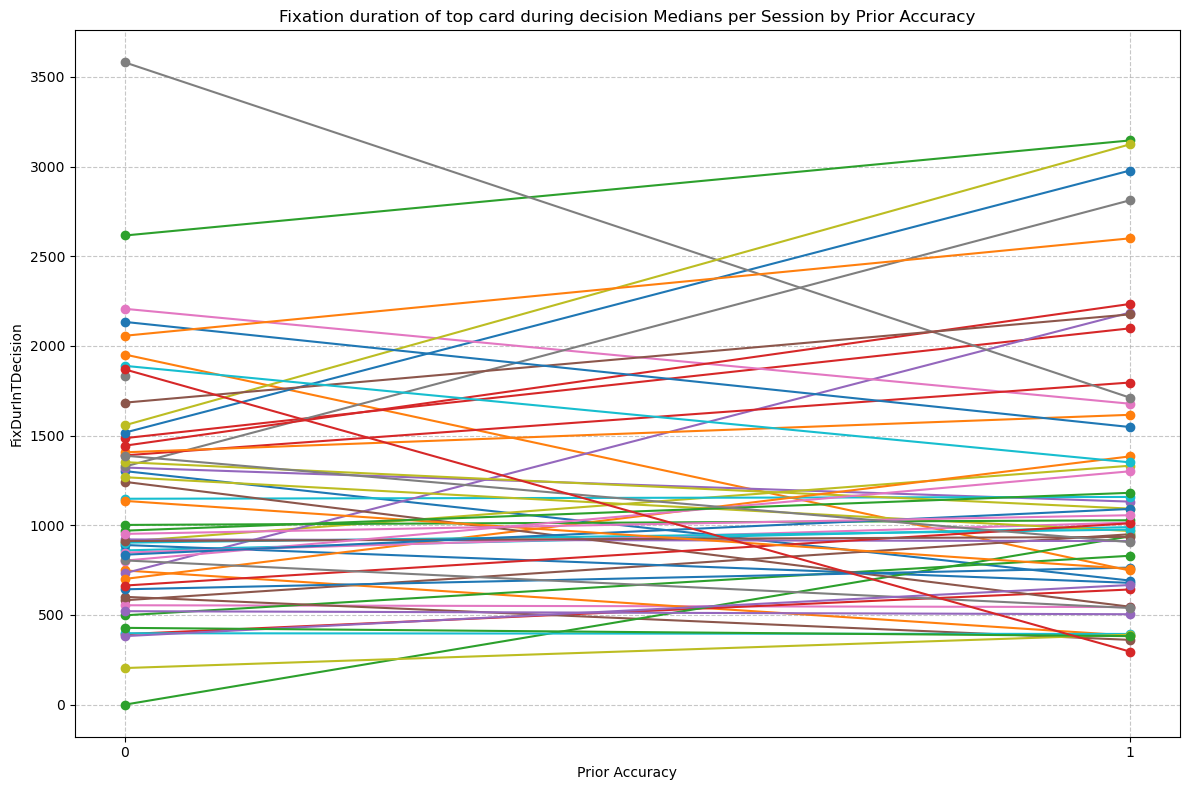

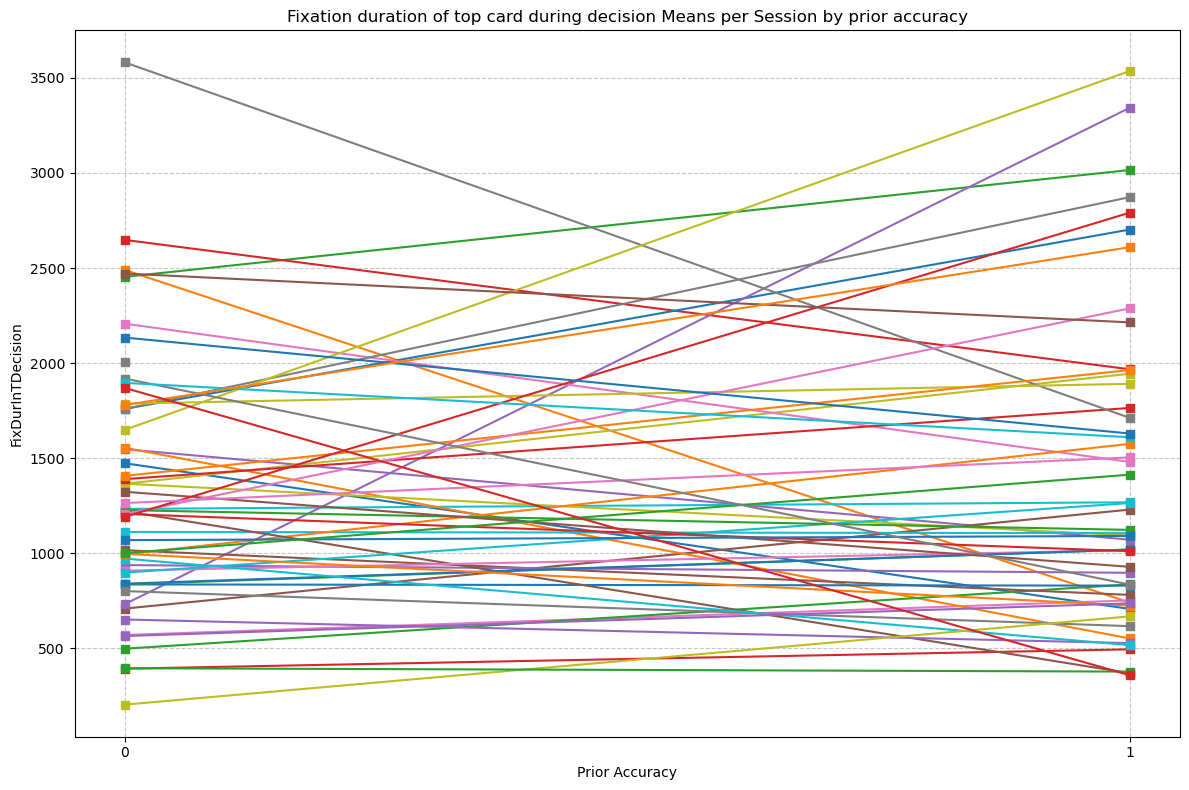

In [96]:
#Fixation duration of top card during decision per session by prior accuracy per session

#Medians
session_fix_decision = data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_fix_decision.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_FixDurInTDecision_session = session_fix_decision.loc[session][available_prior_accuracy]
        plt.plot(median_FixDurInTDecision_session.index, median_FixDurInTDecision_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Fixation duration of top card during decision Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('FixDurInTDecision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_fix_decision_mean = data.groupby(['session', 'prior_accuracy'])['FixDurInTDecision'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_fix_decision_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_FixDurInTDecision_session = session_fix_decision_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_FixDurInTDecision_session.index, mean_FixDurInTDecision_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Fixation duration of top card during decision Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('FixDurInTDecision')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Fixation Duration of Bottom Cards (Exploration Period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 6.278929424251538e-17
Shapiro-Wilk test for 1.0: p-value = 7.129639834600649e-14
Levene's test for homogeneity of variances: p-value = 0.7899368001062816
Kruskal-Wallis test:
H-statistic: 0.03571577156784354
p-value: 0.8501036580430728
Mean Fixation Duration during Exploration of Bottom cards by Prior Accuracy:
prior_accuracy
0.0    2992.740214
1.0    2929.947214
Name: durfixBottomExploration, dtype: float64
SEM Fixation Duration during Exploration of Bottom Cards by Prior Accuracy:
prior_accuracy
0.0    154.416839
1.0    128.192123
Name: durfixBottomExploration, dtype: float64


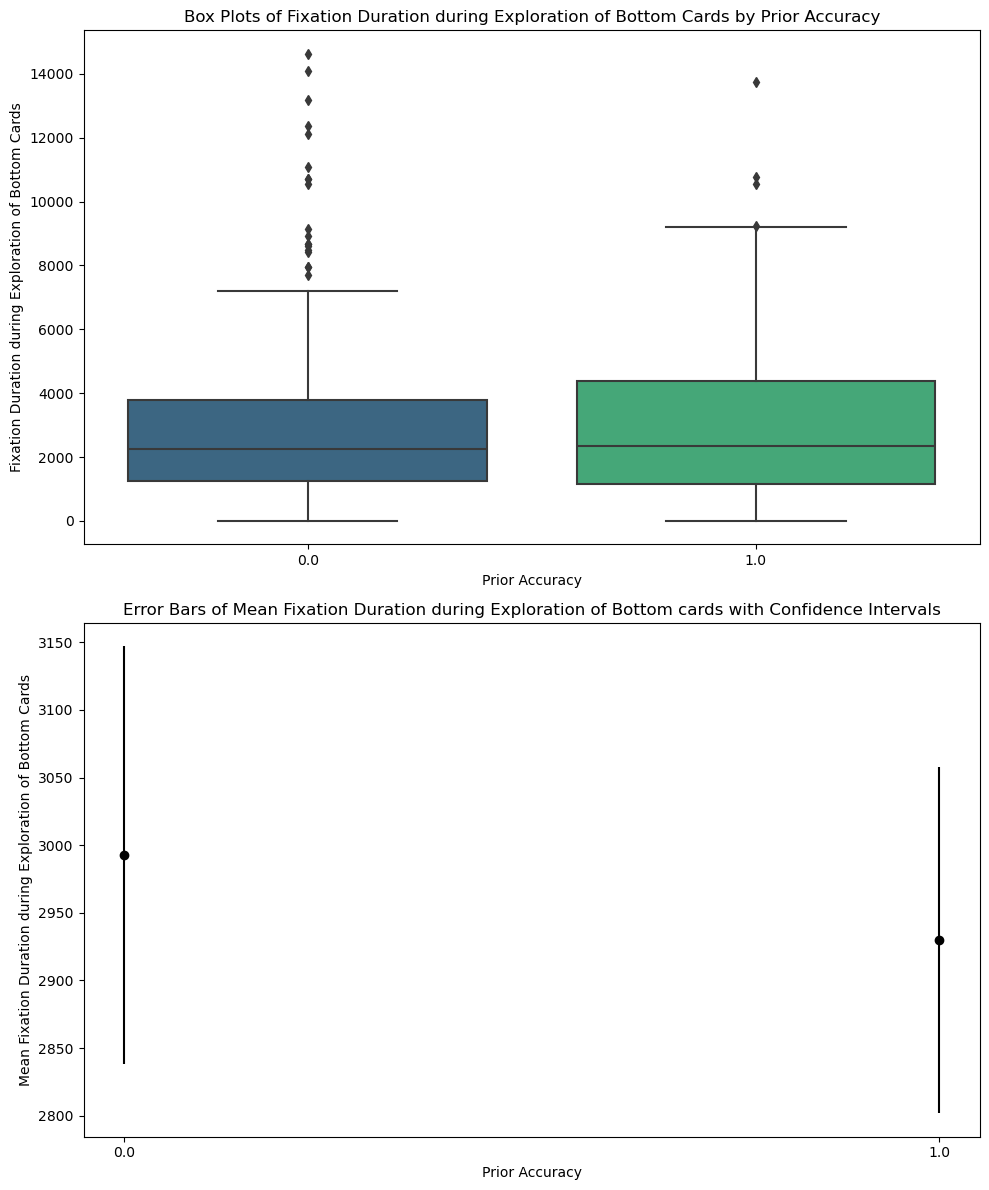

In [97]:
# Fixation Duration of Bottom Cards (exploration Period) vs prior accuracy

durfixBottomExploration_by_prior_accuracy = [data[data['prior_accuracy'] == level]['durfixBottomExploration'] for level in data['prior_accuracy'].unique()]
durfixBottomExploration_by_prior_accuracy = [group.dropna() for group in durfixBottomExploration_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['durfixBottomExploration']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*durfixBottomExploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*durfixBottomExploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of exploration of bottom cards fixation duration by prior accuracy
mean_fixduration_by_prior_accuracy = data.groupby('prior_accuracy')['durfixBottomExploration'].mean()
sem_fixduration_by_prior_accuracy = data.groupby('prior_accuracy')['durfixBottomExploration'].sem()
print("Mean Fixation Duration during Exploration of Bottom cards by Prior Accuracy:")
print(mean_fixduration_by_prior_accuracy)
print("SEM Fixation Duration during Exploration of Bottom Cards by Prior Accuracy:")
print(sem_fixduration_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='durfixBottomExploration', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Fixation Duration during Exploration of Bottom Cards')
ax1.set_title('Box Plots of Fixation Duration during Exploration of Bottom Cards by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_fixduration_by_prior_accuracy)), mean_fixduration_by_prior_accuracy, yerr=sem_fixduration_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Mean Fixation Duration during Exploration of Bottom Cards')
ax2.set_title('Error Bars of Mean Fixation Duration during Exploration of Bottom cards with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_fixduration_by_prior_accuracy)))
ax2.set_xticklabels(mean_fixduration_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

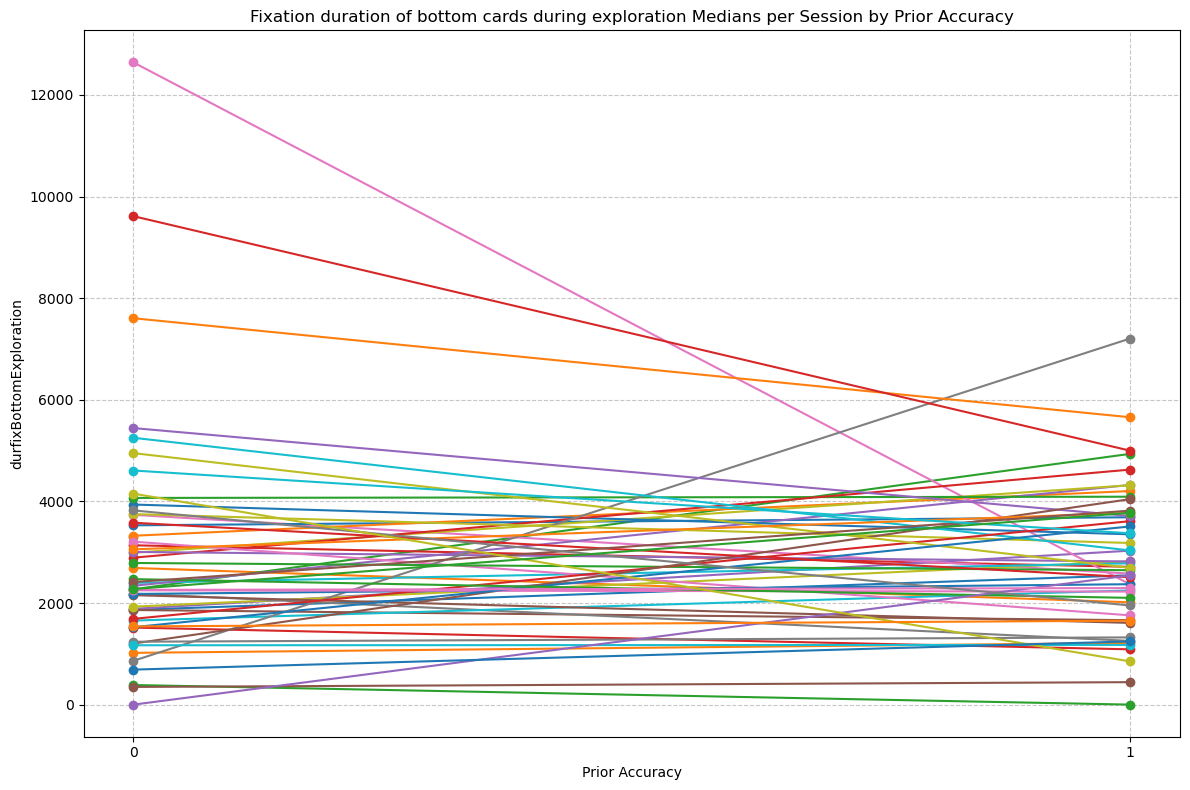

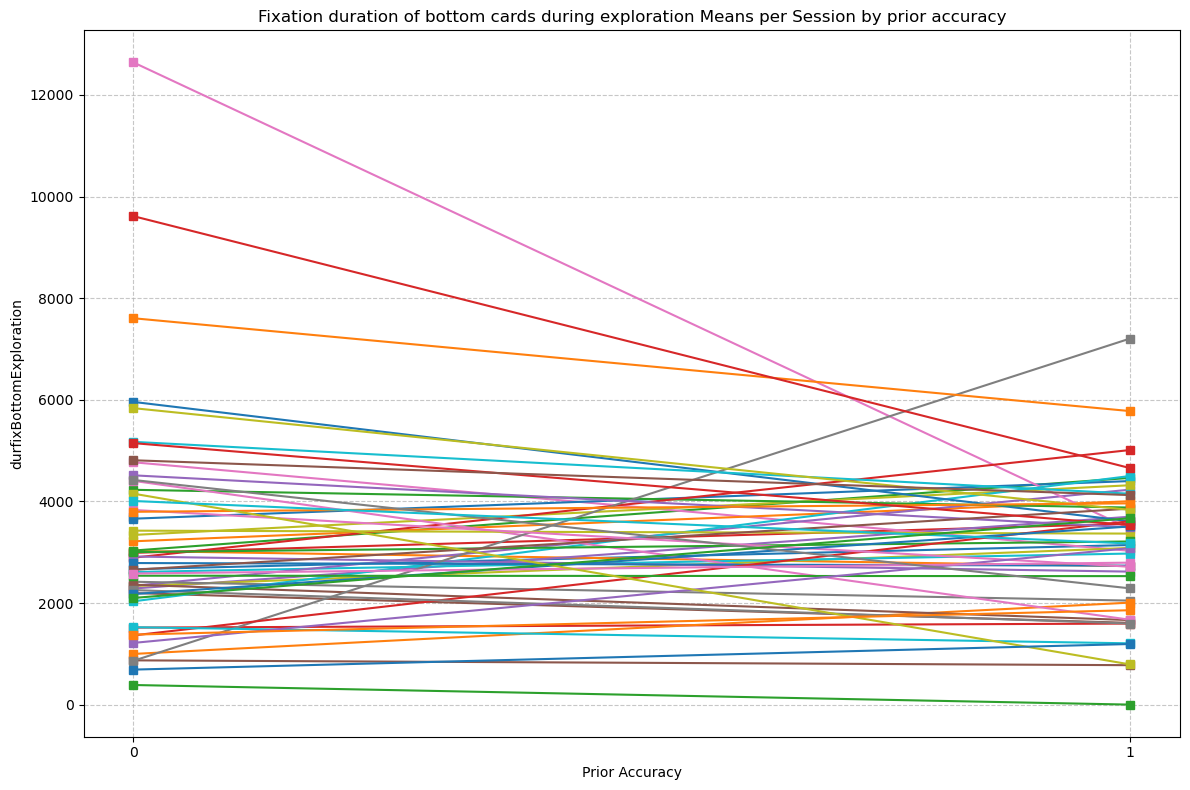

In [98]:
#Fixation duration of bottom cards during exploration per session by prior accuracy per session

#Medians
session_fix_exploration = data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_fix_exploration.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_durfixBottom_session = session_fix_exploration.loc[session][available_prior_accuracy]
        plt.plot(median_durfixBottom_session.index, median_durfixBottom_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Fixation duration of bottom cards during exploration Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('durfixBottomExploration')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_fix_exploration_mean = data.groupby(['session', 'prior_accuracy'])['durfixBottomExploration'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_fix_exploration_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_durfixBottom_session = session_fix_exploration_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_durfixBottom_session.index, mean_durfixBottom_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Fixation duration of bottom cards during exploration Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('durfixBottomExploration')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Number of Switches between bottom cards (exploration period) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 1.1395783605342104e-16
Shapiro-Wilk test for 1.0: p-value = 1.3214383029504813e-15
Levene's test for homogeneity of variances: p-value = 0.3236442897014069
Kruskal-Wallis test:
H-statistic: 0.12986016653496452
p-value: 0.718577067086355
Mean Switches Exploration Period by Prior Accuracy:
prior_accuracy
0.0    2.199288
1.0    2.246334
Name: SwitchesExplorationPeriod, dtype: float64
SEM Switches Exploration Period by Prior Accuracy:
prior_accuracy
0.0    0.079625
1.0    0.075295
Name: SwitchesExplorationPeriod, dtype: float64


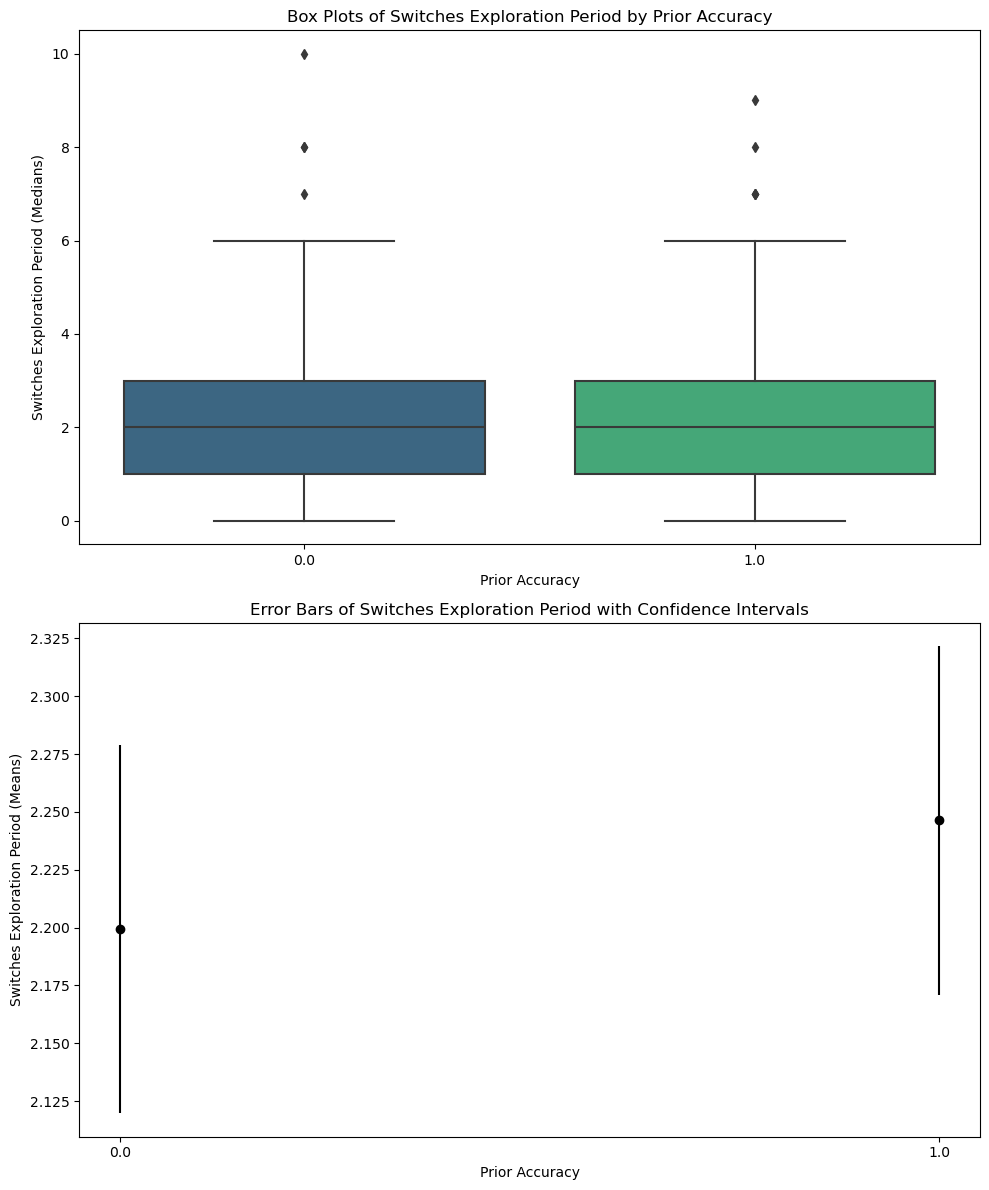

In [99]:
#Switches by prior accuracy (exploration period)

Switches_Exploration_by_prior_accuracy = [data[data['prior_accuracy'] == level]['SwitchesExplorationPeriod'] for level in data['prior_accuracy'].unique()]
Switches_Exploration_by_prior_accuracy = [group.dropna() for group in Switches_Exploration_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['SwitchesExplorationPeriod']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*Switches_Exploration_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*Switches_Exploration_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of FixNb by accuracy
mean_Switches_Exploration_by_prior_accuracy = data.groupby('prior_accuracy')['SwitchesExplorationPeriod'].mean()
sem_Switches_Exploration_by_prior_accuracy = data.groupby('prior_accuracy')['SwitchesExplorationPeriod'].sem()
print("Mean Switches Exploration Period by Prior Accuracy:")
print(mean_Switches_Exploration_by_prior_accuracy)
print("SEM Switches Exploration Period by Prior Accuracy:")
print(sem_Switches_Exploration_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='SwitchesExplorationPeriod', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Switches Exploration Period (Medians)')
ax1.set_title('Box Plots of Switches Exploration Period by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_Switches_Exploration_by_prior_accuracy)), mean_Switches_Exploration_by_prior_accuracy, yerr=sem_Switches_Exploration_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Switches Exploration Period (Means)')
ax2.set_title('Error Bars of Switches Exploration Period with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_Switches_Exploration_by_prior_accuracy)))
ax2.set_xticklabels(mean_Switches_Exploration_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

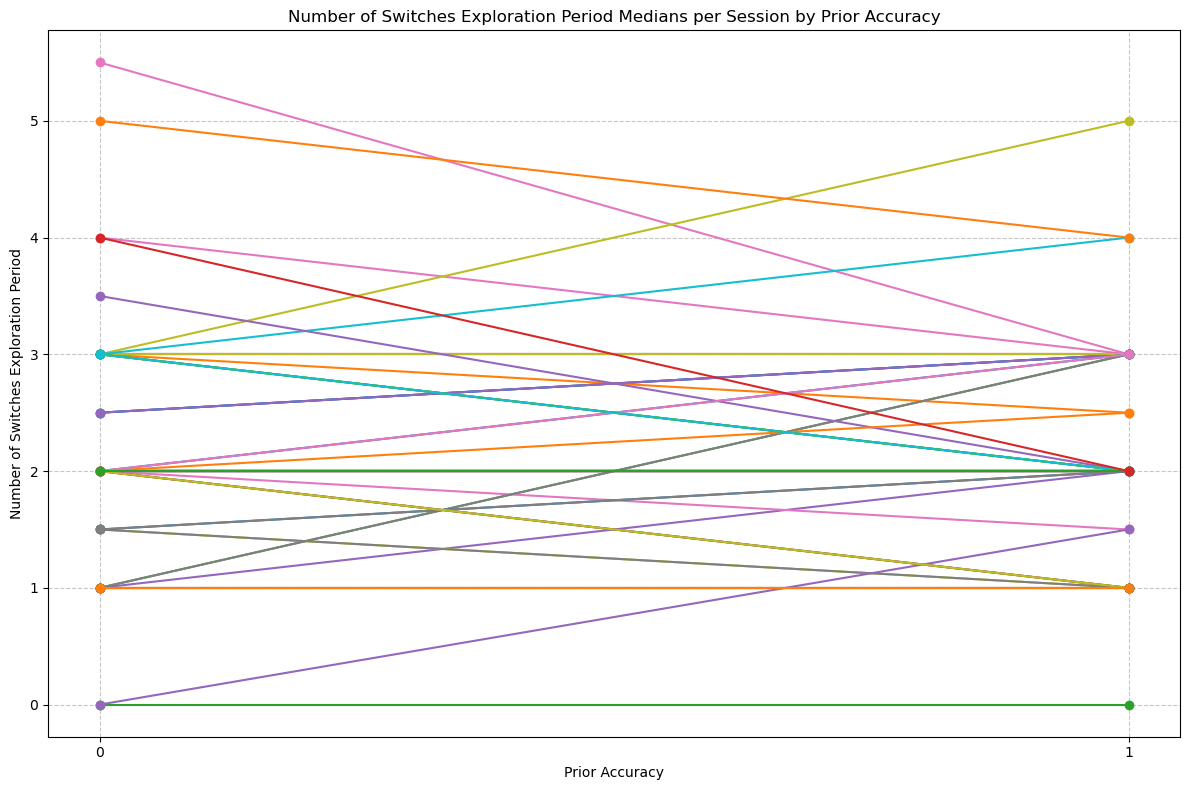

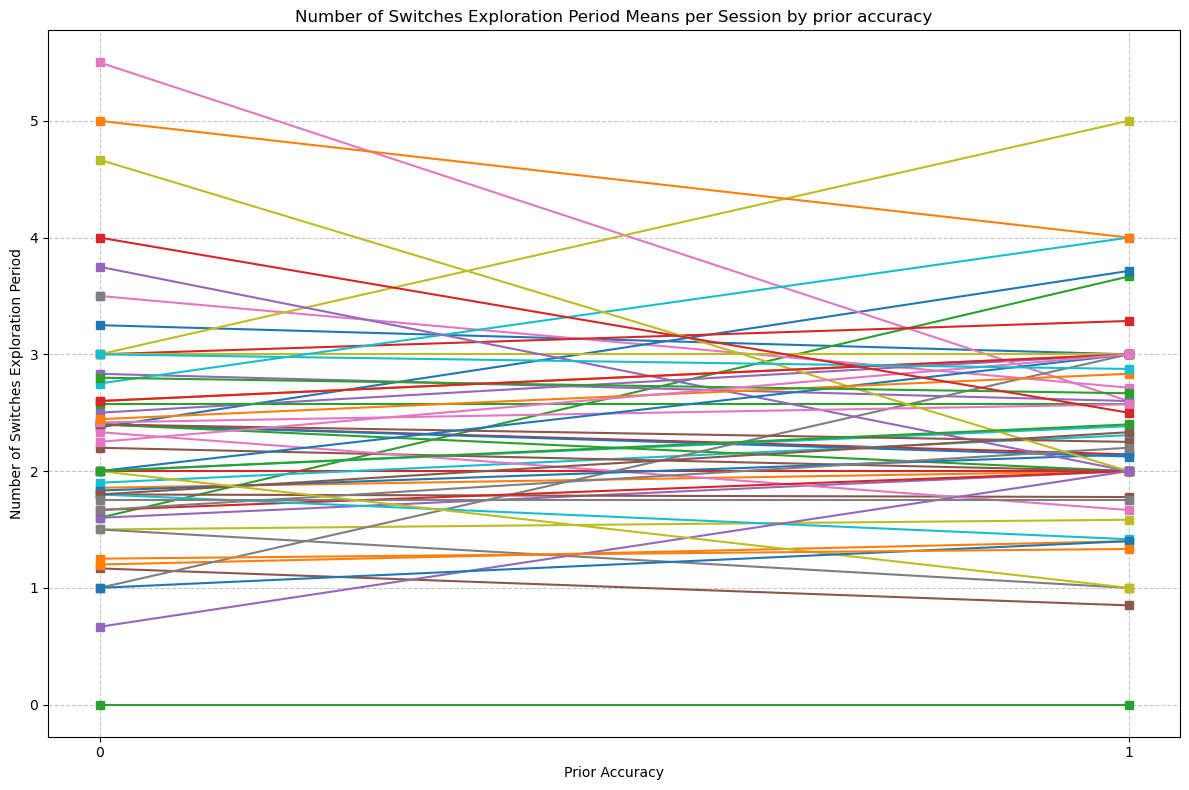

In [100]:
# Number of switches per session during Exploration Period by prior accuracy per session

#Medians
session_SwitchesExplorationPeriod = data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_SwitchesExplorationPeriod.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_SwitchesExplorationPeriod_session = session_SwitchesExplorationPeriod.loc[session][available_prior_accuracy]
        plt.plot(median_SwitchesExplorationPeriod_session.index, median_SwitchesExplorationPeriod_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Number of Switches Exploration Period Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Number of Switches Exploration Period')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_SwitchesExplorationPeriod_mean = data.groupby(['session', 'prior_accuracy'])['SwitchesExplorationPeriod'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_SwitchesExplorationPeriod_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_SwitchesExplorationPeriod_session = session_SwitchesExplorationPeriod_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_SwitchesExplorationPeriod_session.index, mean_SwitchesExplorationPeriod_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Number of Switches Exploration Period Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Number of Switches Exploration Period')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Total number of Switches (both periods) vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 2.1098567931007406e-15
Shapiro-Wilk test for 1.0: p-value = 1.0662784041191218e-13
Levene's test for homogeneity of variances: p-value = 0.4775611280178209
Kruskal-Wallis test:
H-statistic: 0.01654754755692569
p-value: 0.8976446731076823
Mean Number of Switches by Prior Accuracy:
prior_accuracy
0.0    2.701068
1.0    2.715543
Name: NbSwitches, dtype: float64
SEM Number of Switches by Prior Accuracy:
prior_accuracy
0.0    0.088690
1.0    0.080825
Name: NbSwitches, dtype: float64


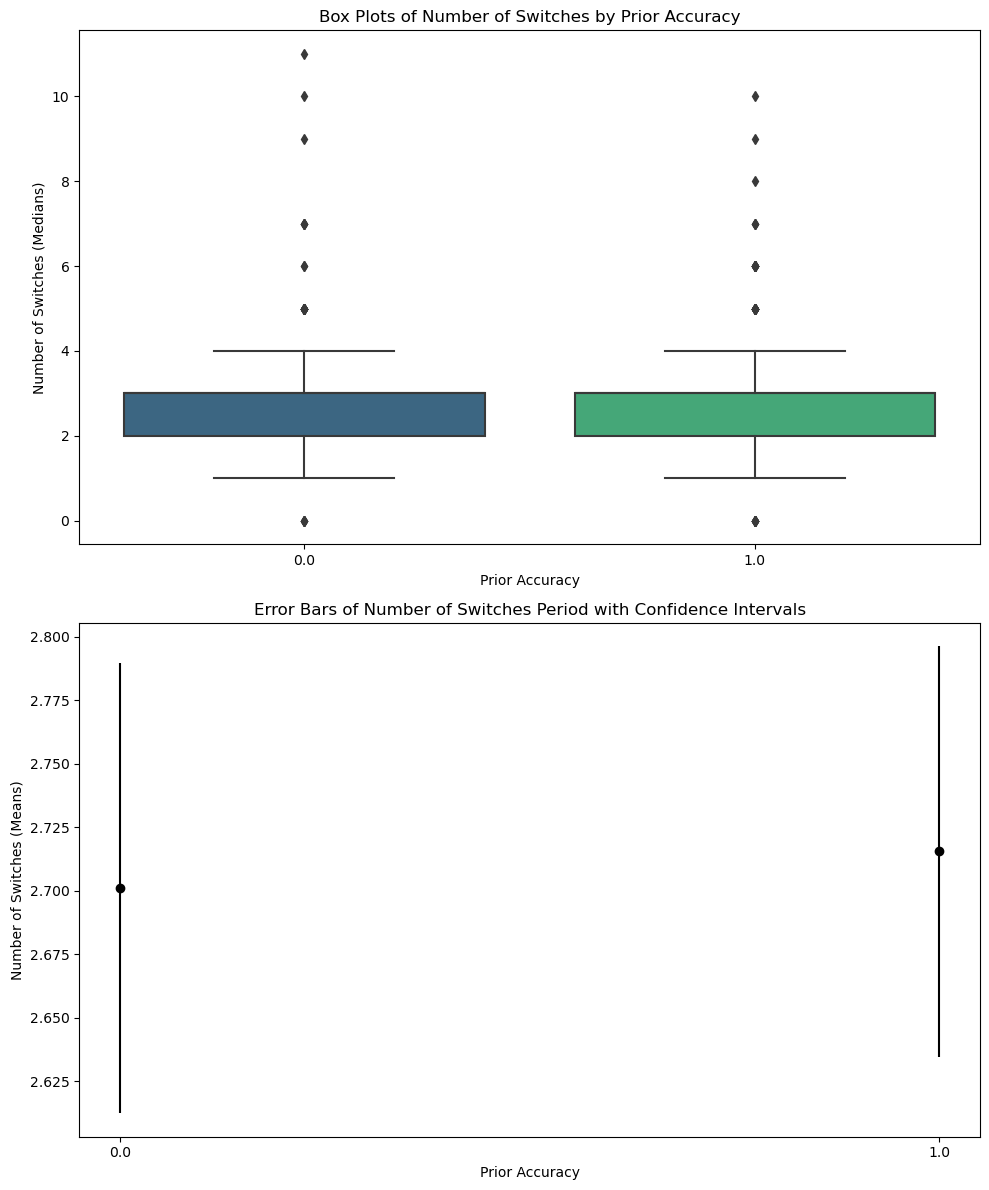

In [101]:
# Number of Switches by prior accuracy 

NbSwitches_by_prior_accuracy = [data[data['prior_accuracy'] == level]['NbSwitches'] for level in data['prior_accuracy'].unique()]
NbSwitches_by_prior_accuracy = [group.dropna() for group in NbSwitches_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['NbSwitches']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")
    
# Levene's test for homogeneity of variances
stat, p = levene(*NbSwitches_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*NbSwitches_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of NbSwitches by accuracy
mean_NbSwitches_by_prior_accuracy = data.groupby('prior_accuracy')['NbSwitches'].mean()
sem_NbSwitches_by_prior_accuracy = data.groupby('prior_accuracy')['NbSwitches'].sem()
print("Mean Number of Switches by Prior Accuracy:")
print(mean_NbSwitches_by_prior_accuracy)
print("SEM Number of Switches by Prior Accuracy:")
print(sem_NbSwitches_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='NbSwitches', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Number of Switches (Medians)')
ax1.set_title('Box Plots of Number of Switches by Prior Accuracy')

ax2.errorbar(np.arange(len(mean_NbSwitches_by_prior_accuracy)), mean_NbSwitches_by_prior_accuracy, yerr=sem_NbSwitches_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Number of Switches (Means)')
ax2.set_title('Error Bars of Number of Switches Period with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_NbSwitches_by_prior_accuracy)))
ax2.set_xticklabels(mean_NbSwitches_by_prior_accuracy.index)

plt.tight_layout()
plt.show()

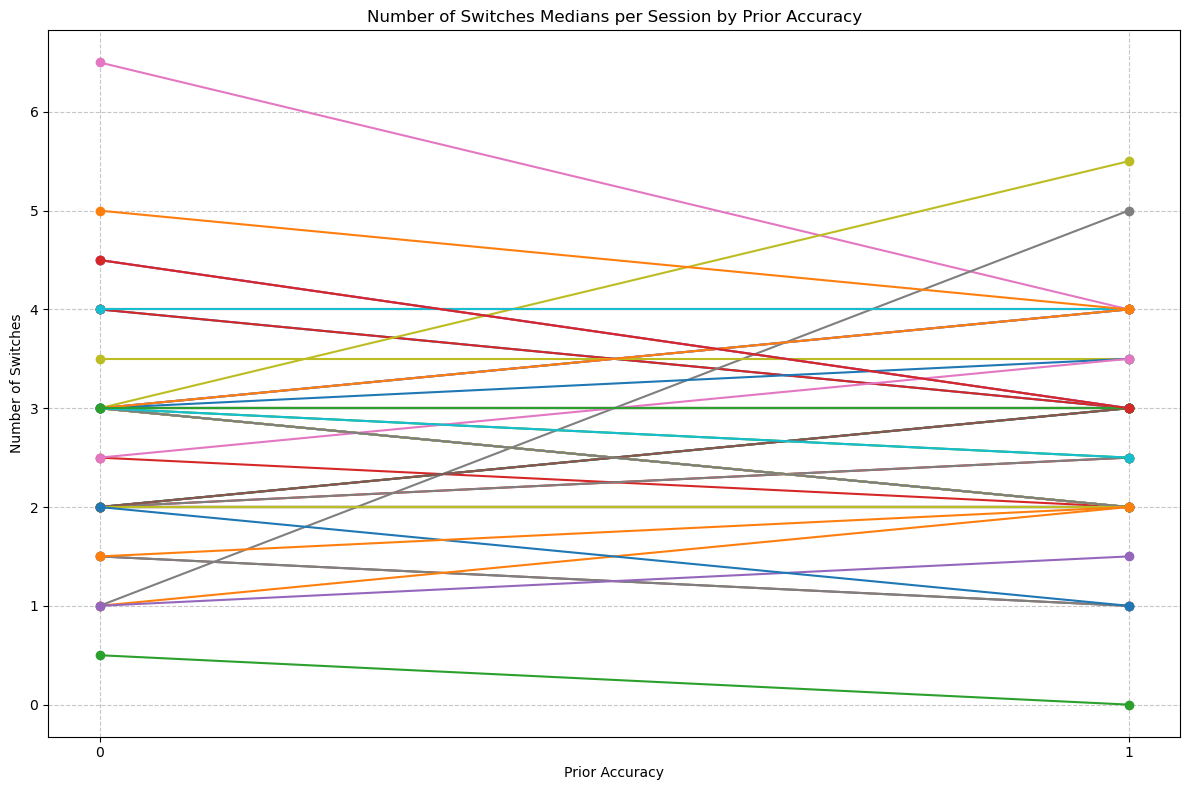

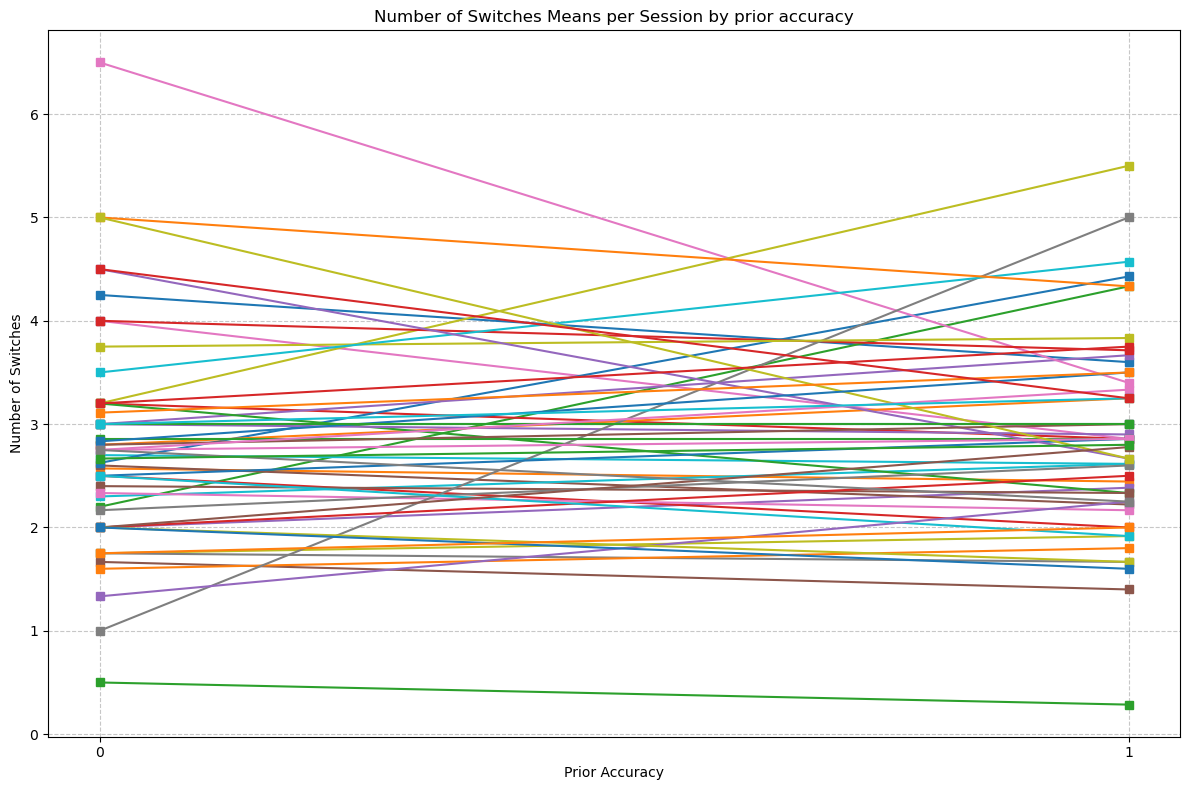

In [102]:
# Number of switches per session by prior accuracy per session

#Medians
session_NbSwitches = data.groupby(['session', 'prior_accuracy'])['NbSwitches'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_NbSwitches.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_NbSwitches_session = session_NbSwitches.loc[session][available_prior_accuracy]
        plt.plot(median_NbSwitches_session.index, median_NbSwitches_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Number of Switches Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Number of Switches')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
plt.tight_layout()
#plt.legend()
plt.show()

session_NbSwitches_mean = data.groupby(['session', 'prior_accuracy'])['NbSwitches'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_NbSwitches_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_NbSwitches_session = session_NbSwitches_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_NbSwitches_session.index, mean_NbSwitches_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Number of Switches Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Number of Switches')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1])
#plt.legend()
plt.tight_layout()
plt.show()

### Side Chosen vs. Prior Accuracy

Shapiro-Wilk test for 0.0: p-value = 3.723502829544884e-24
Shapiro-Wilk test for 1.0: p-value = 1.316690499712016e-26
Levene's test for homogeneity of variances: p-value = 0.43238694145447365
Kruskal-Wallis test:
H-statistic: 0.617588390292582
p-value: 0.4319448694161774
Mean Side Chosen by Prior Accuracy:
prior_accuracy
0.0    0.44484
1.0    0.41349
Name: sideChosen, dtype: float64
Median Side Chosen by Prior Accuracy:
prior_accuracy
0.0    0.0
1.0    0.0
Name: sideChosen, dtype: float64
SEM Side Chosen by Prior Accuracy:
prior_accuracy
0.0    0.029698
1.0    0.026707
Name: sideChosen, dtype: float64


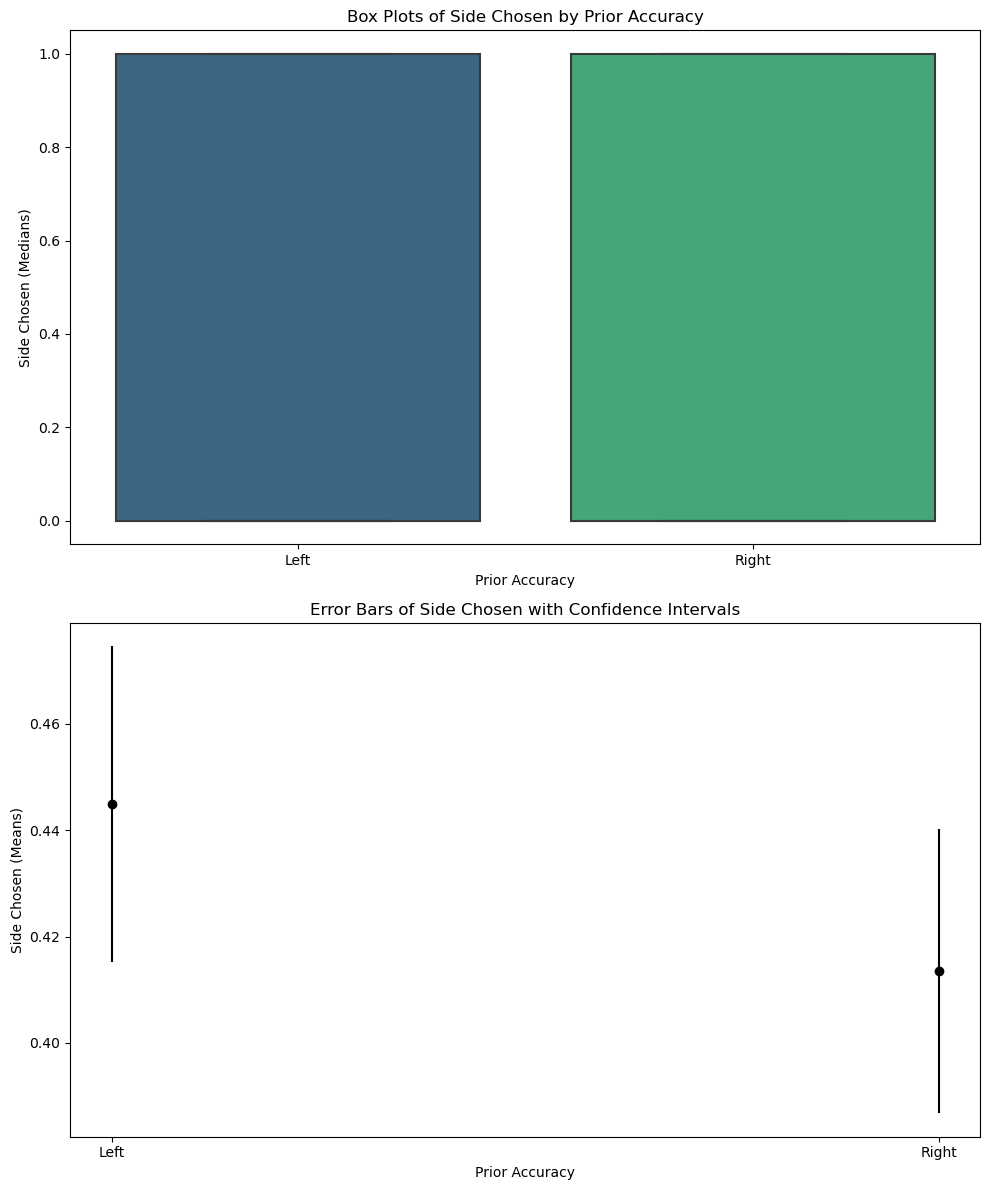

In [103]:
# Side Chosen by prior accuracy 

# Convert 'sideChosen' to numerical values (0 for left, 1 for right)
data['sideChosen'] = data['sideChosen'].map({'left': 0, 'right': 1})

# Side Chosen by prior accuracy 
sideChosen_by_prior_accuracy = [data[data['prior_accuracy'] == level]['sideChosen'] for level in data['prior_accuracy'].unique()]
sideChosen_by_prior_accuracy = [group.dropna() for group in sideChosen_by_prior_accuracy]

# Shapiro-Wilk test for normality
for group_name, group_data in data.groupby('prior_accuracy')['sideChosen']:
    stat, p = shapiro(group_data)
    print(f"Shapiro-Wilk test for {group_name}: p-value = {p}")

# Levene's test for homogeneity of variances
stat, p = levene(*sideChosen_by_prior_accuracy)
print(f"Levene's test for homogeneity of variances: p-value = {p}")

# Kruskal-Wallis test
H, p = kruskal(*sideChosen_by_prior_accuracy)
print("Kruskal-Wallis test:")
print("H-statistic:", H)
print("p-value:", p)

# Mean and SEM of NbSwitches by accuracy
mean_sideChosen_by_prior_accuracy = data.groupby('prior_accuracy')['sideChosen'].mean()
sem_sideChosen_by_prior_accuracy = data.groupby('prior_accuracy')['sideChosen'].sem()
median_sideChosen_by_prior_accuracy = data.groupby('prior_accuracy')['sideChosen'].median()
print("Mean Side Chosen by Prior Accuracy:")
print(mean_sideChosen_by_prior_accuracy)
print("Median Side Chosen by Prior Accuracy:")
print(median_sideChosen_by_prior_accuracy)
print("SEM Side Chosen by Prior Accuracy:")
print(sem_sideChosen_by_prior_accuracy)

# Plots
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.boxplot(x='prior_accuracy', y='sideChosen', data=data, palette='viridis', ax=ax1)
ax1.set_xlabel('Prior Accuracy')
ax1.set_ylabel('Side Chosen (Medians)')
ax1.set_title('Box Plots of Side Chosen by Prior Accuracy')
ax1.set_xticklabels(['Left', 'Right'])  # Replace numerical values with labels

ax2.errorbar(np.arange(len(mean_sideChosen_by_prior_accuracy)), mean_sideChosen_by_prior_accuracy, yerr=sem_sideChosen_by_prior_accuracy, fmt='o', color='black')
ax2.set_xlabel('Prior Accuracy')
ax2.set_ylabel('Side Chosen (Means)')
ax2.set_title('Error Bars of Side Chosen with Confidence Intervals')
ax2.set_xticks(np.arange(len(mean_sideChosen_by_prior_accuracy)))
ax2.set_xticklabels(mean_sideChosen_by_prior_accuracy.index)
ax2.set_xticklabels(['Left', 'Right'])  # Replace numerical values with labels

plt.tight_layout()
plt.show()

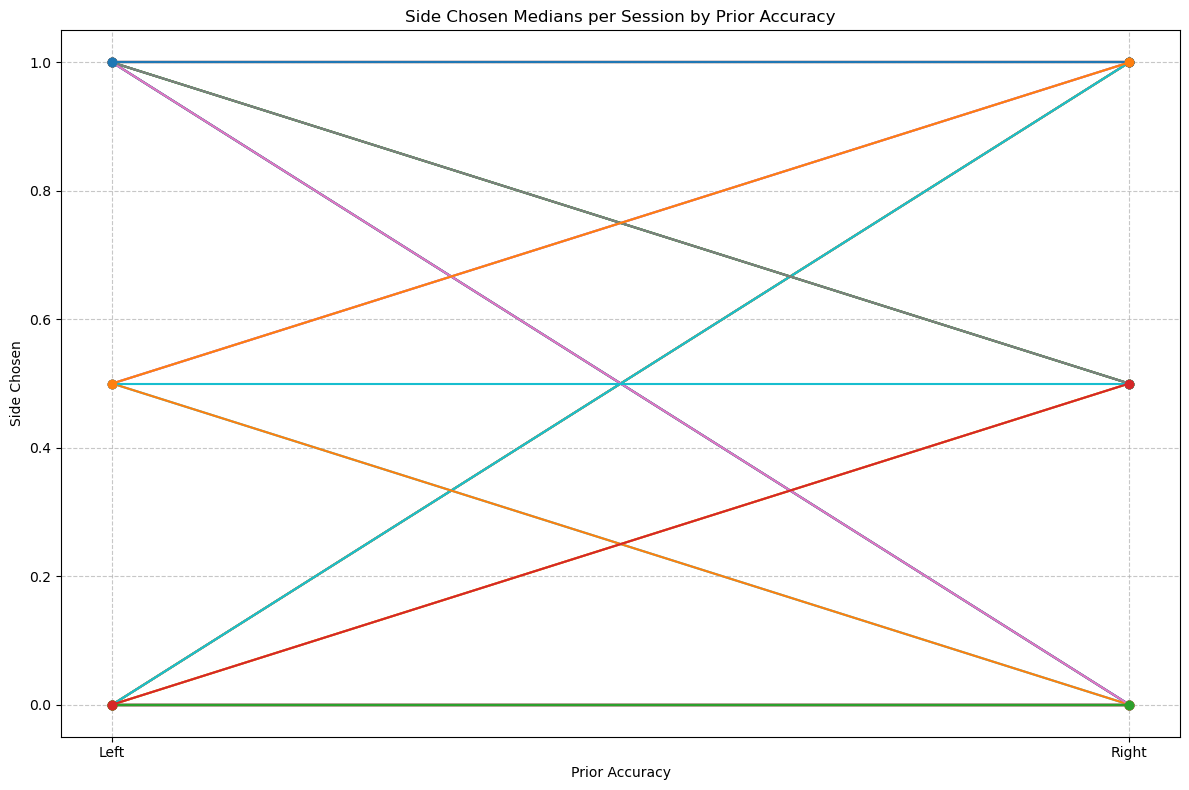

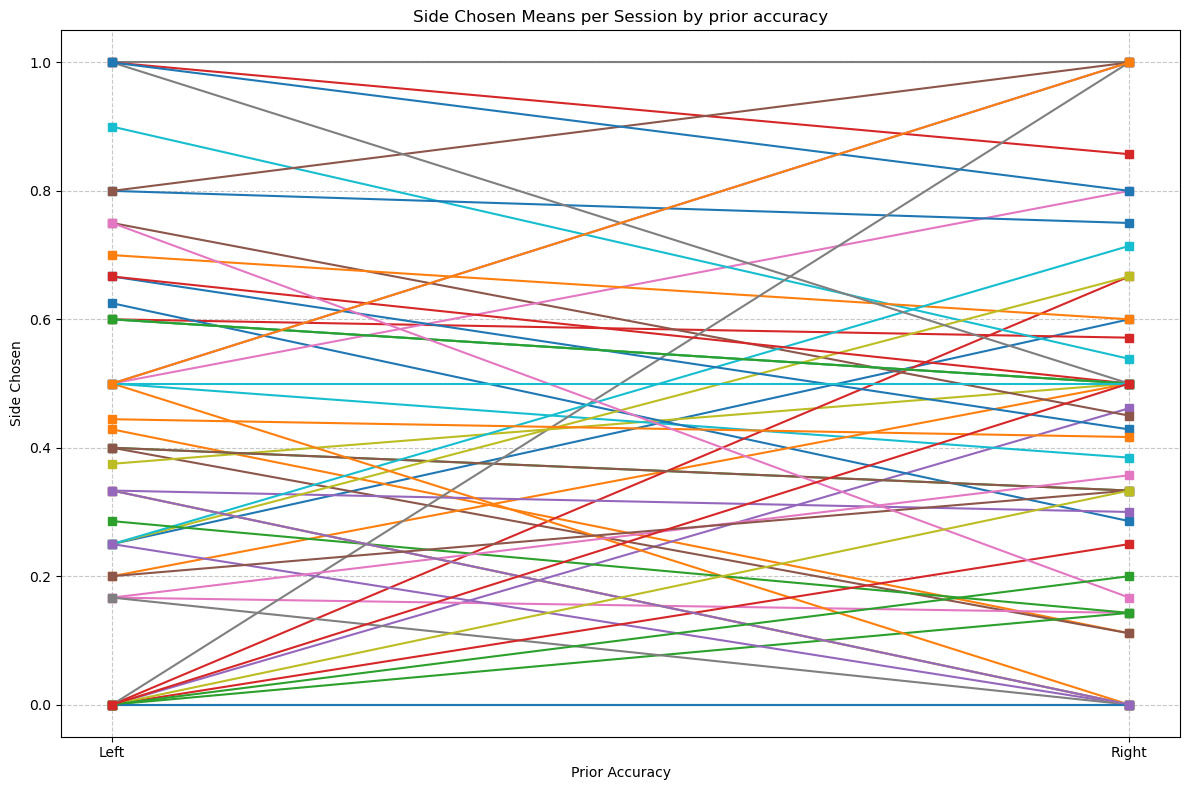

In [108]:
# Side Chosen by prior accuracy per session

data['sideChosen'] = data['sideChosen'].map({'left': 0, 'right': 1})

#Medians
session_sideChosen = data.groupby(['session', 'prior_accuracy'])['sideChosen'].median().unstack()

sessions = data['session'].unique()

plt.figure(figsize=(12, 8))

for session in sessions:
    available_prior_accuracy = session_sideChosen.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        median_sideChosen_session = session_sideChosen.loc[session][available_prior_accuracy]
        plt.plot(median_sideChosen_session.index, median_sideChosen_session, marker='o', linestyle='-', label=f'Session {session}')
        
plt.title('Side Chosen Medians per Session by Prior Accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Side Chosen')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['Left', 'Right'])
plt.tight_layout()
#plt.legend()
plt.show()

session_sideChosen_mean = data.groupby(['session', 'prior_accuracy'])['sideChosen'].mean().unstack()

# Means
plt.figure(figsize=(12, 8))
for session in sessions:
    available_prior_accuracy = session_sideChosen_mean.loc[session].dropna().index.tolist()
    if available_prior_accuracy:
        mean_sideChosen_session = session_sideChosen_mean.loc[session][available_prior_accuracy]
        plt.plot(mean_sideChosen_session.index, mean_sideChosen_session, marker='s', linestyle='-', label=f'Mean - Session {session}')

plt.title('Side Chosen Means per Session by prior accuracy')
plt.xlabel('Prior Accuracy')
plt.ylabel('Side Chosen')
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks([0, 1], ['Left', 'Right'])
#plt.legend()
plt.tight_layout()
plt.show()

## Modeling 

### Trial Duration vs. Prior_Accuracy

In [8]:
#Mixed effects model: HIERARCHICAL 
# Method: REML
# Variable: durPeriodTotal
# Distribution: Weibull 

from scipy.special import expit

# Compute logistic transformation using expit
data['logistic_prior_accuracy'] = expit(data['prior_accuracy'] + 0.001)

# Transform trial duration to fit a Weibull distribution
data['transformed_durPeriodTotal'] = np.log(data['durPeriodTotal'] + 0.001)

# Convert 'session' to categorical
data['session'] = data['session'].astype('category')


# Define the formula with the interaction variable for random slope
formula = 'transformed_durPeriodTotal ~ logistic_prior_accuracy + np.power(logistic_prior_accuracy, 2)'

# Create the mixed effects hierarchical model
mixed_model = sm.MixedLM.from_formula(formula, groups=data['session'], data=data)

# Fit the model
result = mixed_model.fit()

# Print the summary
print(result.summary()) + 0.001)

# Leave-One-Out Cross-Validation (LOO-CV)

#actual_values = []
#predicted_values = []

#for idx, row in data.iterrows():
#    leave_one_out_data = data.drop(index=idx)

#    mixed_model = sm.MixedLM.from_formula(formula, data=leave_one_out_data, groups=leave_one_out_data['session'])
#    result = mixed_model.fit()

#    prediction_data = pd.DataFrame([row], columns=data.columns)

#    predicted_value = result.predict(prediction_data)

#    actual_values.append(row['transformed_durPeriodTotal'])
#    predicted_values.append(predicted_value)

# Mean Absolute Error (MAE)
#mae = mean_absolute_error(actual_values, predicted_values)
#print("\nMean Absolute Error:", mae)

# Mean Squared Error (MSE)
#mse = mean_squared_error(actual_values, predicted_values)
#print("Mean Squared Error:", mse)

SyntaxError: unmatched ')' (25475963.py, line 28)

In [6]:
# Compute logistic transformation using expit
data['logistic_prior_accuracy'] = expit(data['prior_accuracy'])

# Transform trial duration to fit a Weibull distribution
data['transformed_durPeriodTotal'] = np.log(data['durPeriodTotal'] + 0.001)

# Convert 'session' to categorical
data['session'] = data['session'].astype('category')

# Create interaction variable for random slope
data['interaction_logistic_prior_accuracy_session'] = data['logistic_prior_accuracy'] * data['session'].cat.codes

# Define the formula with the interaction variable for random slope
formula = 'transformed_durPeriodTotal ~ logistic_prior_accuracy + np.power(logistic_prior_accuracy, 2) + interaction_logistic_prior_accuracy_session'

# Create the mixed effects hierarchical model
mixed_model = sm.MixedLM.from_formula(formula, groups=data['session'], data=data)

# Fit the model
result = mixed_model.fit()

# Print the summary
print(result.summary())

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(


                         Mixed Linear Model Regression Results
Model:                  MixedLM      Dependent Variable:      transformed_durPeriodTotal
No. Observations:       622          Method:                  REML                      
No. Groups:             54           Scale:                   0.2273                    
Min. group size:        3            Log-Likelihood:          -450.3975                 
Max. group size:        32           Converged:               No                        
Mean group size:        11.5                                                            
----------------------------------------------------------------------------------------
                                             Coef.   Std.Err.   z    P>|z| [0.025 0.975]
----------------------------------------------------------------------------------------
Intercept                                    156.782                                    
logistic_prior_accuracy                     -49

C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2207: ConvergenceWarning: MixedLM optimization failed, trying a different optimizer may help.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2219: ConvergenceWarning: Gradient optimization failed, |grad| = 44.278684
  warnings.warn(msg, ConvergenceWarning)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2262: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\I587504\AppData\Local\anaconda3\Lib\site-

In [141]:
import numpy as np
import pymc as pm

data['session'] = data['session'].astype('category').cat.codes

# Define the model
with pm.Model() as model:
    # Priors for fixed effects
    beta_0 = pm.Normal('beta_0', mu=0, sigma=1)
    beta_1 = pm.Normal('beta_1', mu=0, sigma=1)
    beta_2 = pm.Normal('beta_2', mu=0, sigma=1)

    # Random intercept and slope for session
    sigma_session_intercept = pm.HalfNormal('sigma_session_intercept', sigma=1)
    sigma_session_slope = pm.HalfNormal('sigma_session_slope', sigma=1)
    session_intercept = pm.Normal('session_intercept', mu=0, sigma=sigma_session_intercept, shape=len(data['session'].unique()))
    session_slope = pm.Normal('session_slope', mu=0, sigma=sigma_session_slope, shape=len(data['session'].unique()))

    # Link function for binomial predictor
    prior_accuracy_logit = pm.Deterministic('prior_accuracy_logit', pm.math.invlogit(beta_0 + beta_1 * data['prior_accuracy'] + beta_2 * np.power(data['prior_accuracy'], 2)))

    # Linear predictor
    mu = (beta_0 +
          beta_1 * prior_accuracy_logit +
          beta_2 * np.power(prior_accuracy_logit, 2) +
          session_intercept[data['session'].values] +
          session_slope[data['session'].values] * prior_accuracy_logit)

    # Transform mu to ensure it's positive for Weibull distribution
    mu_transformed = pm.Deterministic('mu_transformed', pm.math.exp(mu))

    # Likelihood (Weibull distribution)
    durPeriodTotal = pm.Weibull('durPeriodTotal', alpha=1, beta=mu_transformed, observed=data['durPeriodTotal'])

    # Sampling
    trace = pm.sample(1000, tune=1000)

# View the summary of the model
pm.summary(trace)


ImportError: cannot import name 'gaussian' from 'scipy.signal' (C:\Users\I587504\AppData\Local\anaconda3\Lib\site-packages\scipy\signal\__init__.py)